In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.cluster import KMeans
import seaborn as sns
from statsmodels.datasets import get_rdataset
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

In [143]:
# Load the dataset (AQ)
aq_data = pd.read_csv('Answers-AQ.csv', header=None)
aq_data.columns = [f'AQ{i+1:02d}' for i in range(50)]
aq_data = aq_data.drop(index=0)  # Drop the first row
aq_data.reset_index(drop=True, inplace=True) 
aq_data 

,AQ01,AQ02,AQ03,AQ04,AQ05,AQ06,AQ07,AQ08,AQ09,AQ10,...,AQ41,AQ42,AQ43,AQ44,AQ45,AQ46,AQ47,AQ48,AQ49,AQ50
0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,1,1,0,0,0,...,0,1,1,0,1,0,1,0,0,1
2,1,0,0,1,1,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
921,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
922,1,1,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0
923,0,0,0,0,1,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


In [144]:
# Try different encodings to load the dataset
encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']
ASRS = None

for encoding in encodings:
    try:
        asrs_data = pd.read_csv('Answers-ASRS.csv', encoding=encoding)
        encoding_success = encoding
        break
    except UnicodeDecodeError as e:
        encoding_success = str(e)

encoding_success, asrs_data.head() if asrs_data is not None else None

('latin1',
     ID code  ASRS01  ASRS02  ASRS03  ASRS04  ASRS05  ASRS06  ASRS07  ASRS08  \
 0  qanXRxtJ       1       3       1       3       4       0       1       2   
 1    439255       2       1       1       0       3       4       1       2   
 2  rZdt8NSK       2       3       0       2       2       2       2       3   
 3  IXePNvsw       1       1       1       2       2       2       2       2   
 4      1848       1       2       1       2       2       1       2       1   
 
    ASRS09  ASRS10  ASRS11  ASRS12  ASRS13  ASRS14  ASRS15  ASRS16  ASRS17  \
 0       1       1       1       0       1       0       1       2       1   
 1       2       1       2       1       4       3       2       2       3   
 2       3       2       3       1       1       3       1       4       3   
 3       3       1       2       1       3       1       1       2       1   
 4       1       2       2       0       1       1       1       0       1   
 
    ASRS18  
 0       1  
 1       1 

In [145]:
asrs_data = asrs_data.drop('ID code', axis=1)

In [146]:
# Convert ASRS columns to numeric
asrs_cols = [col for col in asrs_data.columns if col.startswith('ASRS')]
for col in asrs_cols:
    asrs_data[col] = pd.to_numeric(asrs_data[col], errors='coerce')

# Convert AQ columns to numeric
for col in aq_data.columns:
    aq_data[col] = pd.to_numeric(aq_data[col], errors='coerce')

In [147]:
# Basic statistics
print("ASRS Dataset Statistics:")
print(asrs_data[asrs_cols].describe())
print("\nAQ Dataset Statistics:")
print(aq_data.describe())

ASRS Dataset Statistics:
           ASRS01      ASRS02      ASRS03      ASRS04      ASRS05      ASRS06  \
count  925.000000  925.000000  925.000000  925.000000  925.000000  925.000000   
mean     1.825946    1.500541    1.163243    1.911351    2.544865    1.688649   
std      1.129579    1.044077    1.025830    1.159718    1.173936    1.088274   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    0.000000    1.000000    2.000000    1.000000   
50%      2.000000    1.000000    1.000000    2.000000    3.000000    2.000000   
75%      3.000000    2.000000    2.000000    3.000000    3.000000    2.000000   
max      4.000000    4.000000    4.000000    4.000000    4.000000    4.000000   

           ASRS07      ASRS08      ASRS09      ASRS10      ASRS11      ASRS12  \
count  925.000000  925.000000  925.000000  925.000000  925.000000  925.000000   
mean     1.914595    2.250811    1.558919    1.686486    1.882162    0.572973   
st

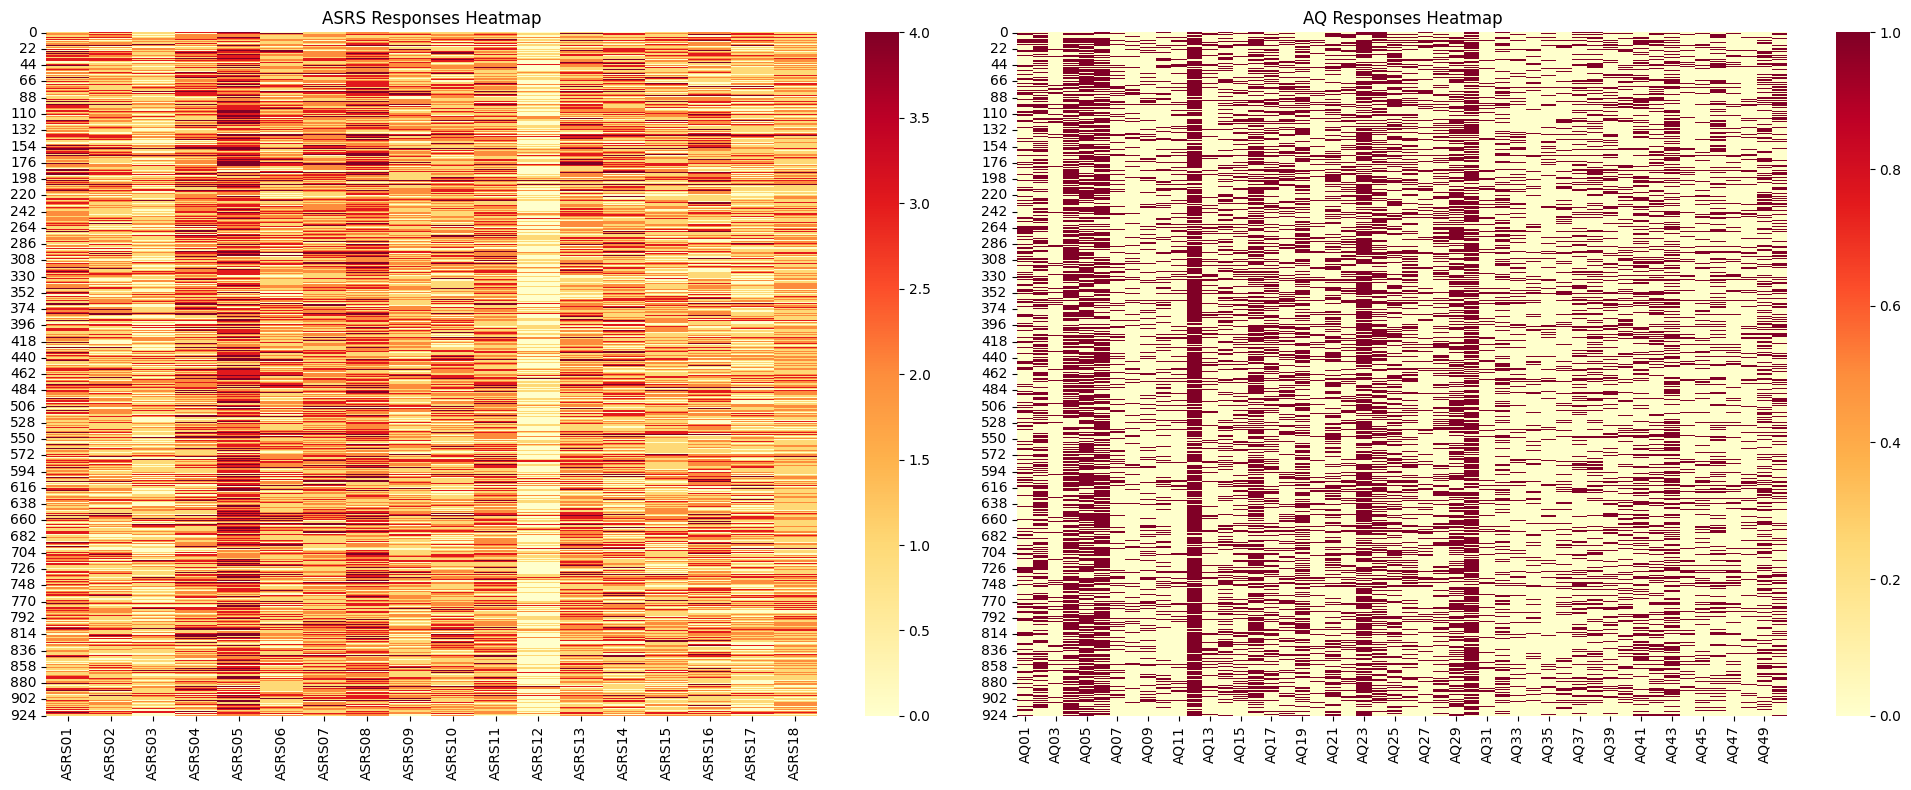

In [148]:
# Visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ASRS Heatmap
sns.heatmap(asrs_data[asrs_cols], cmap='YlOrRd', ax=ax1)
ax1.set_title('ASRS Responses Heatmap')

# AQ Heatmap
sns.heatmap(aq_data, cmap='YlOrRd', ax=ax2)
ax2.set_title('AQ Responses Heatmap')

plt.tight_layout()
plt.show()

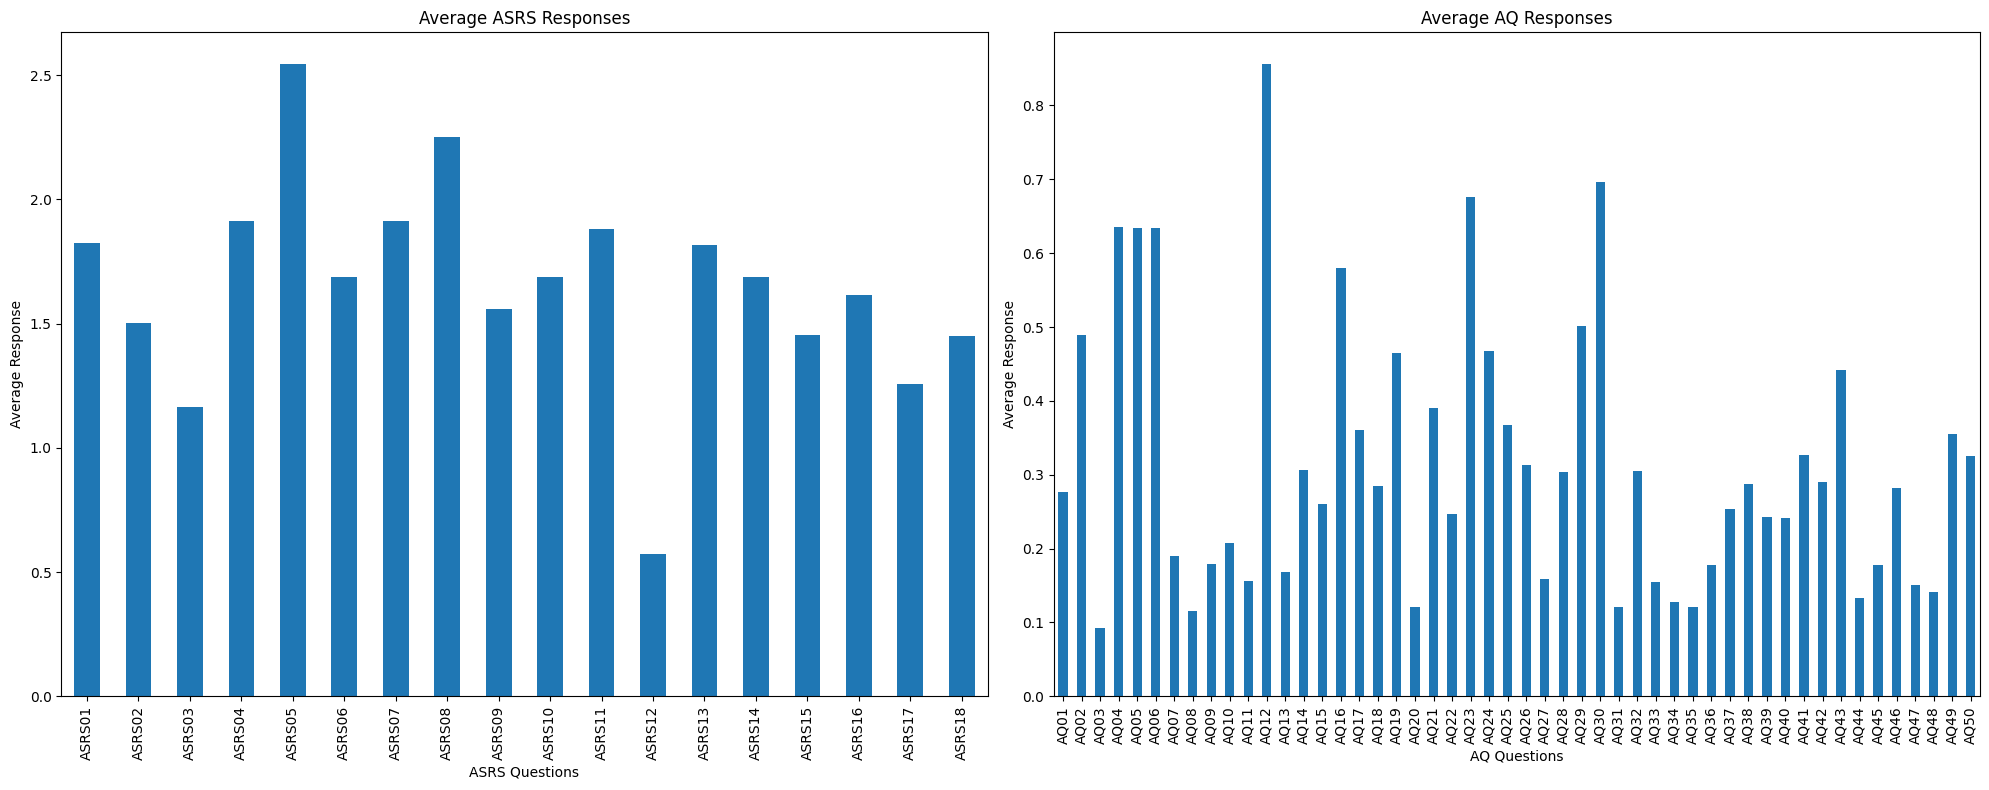

In [149]:
# Distribution of responses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

asrs_data[asrs_cols].mean().plot(kind='bar', ax=ax1)
ax1.set_title('Average ASRS Responses')
ax1.set_xlabel('ASRS Questions')
ax1.set_ylabel('Average Response')

aq_data.mean().plot(kind='bar', ax=ax2)
ax2.set_title('Average AQ Responses')
ax2.set_xlabel('AQ Questions')
ax2.set_ylabel('Average Response')

plt.tight_layout()
plt.show()

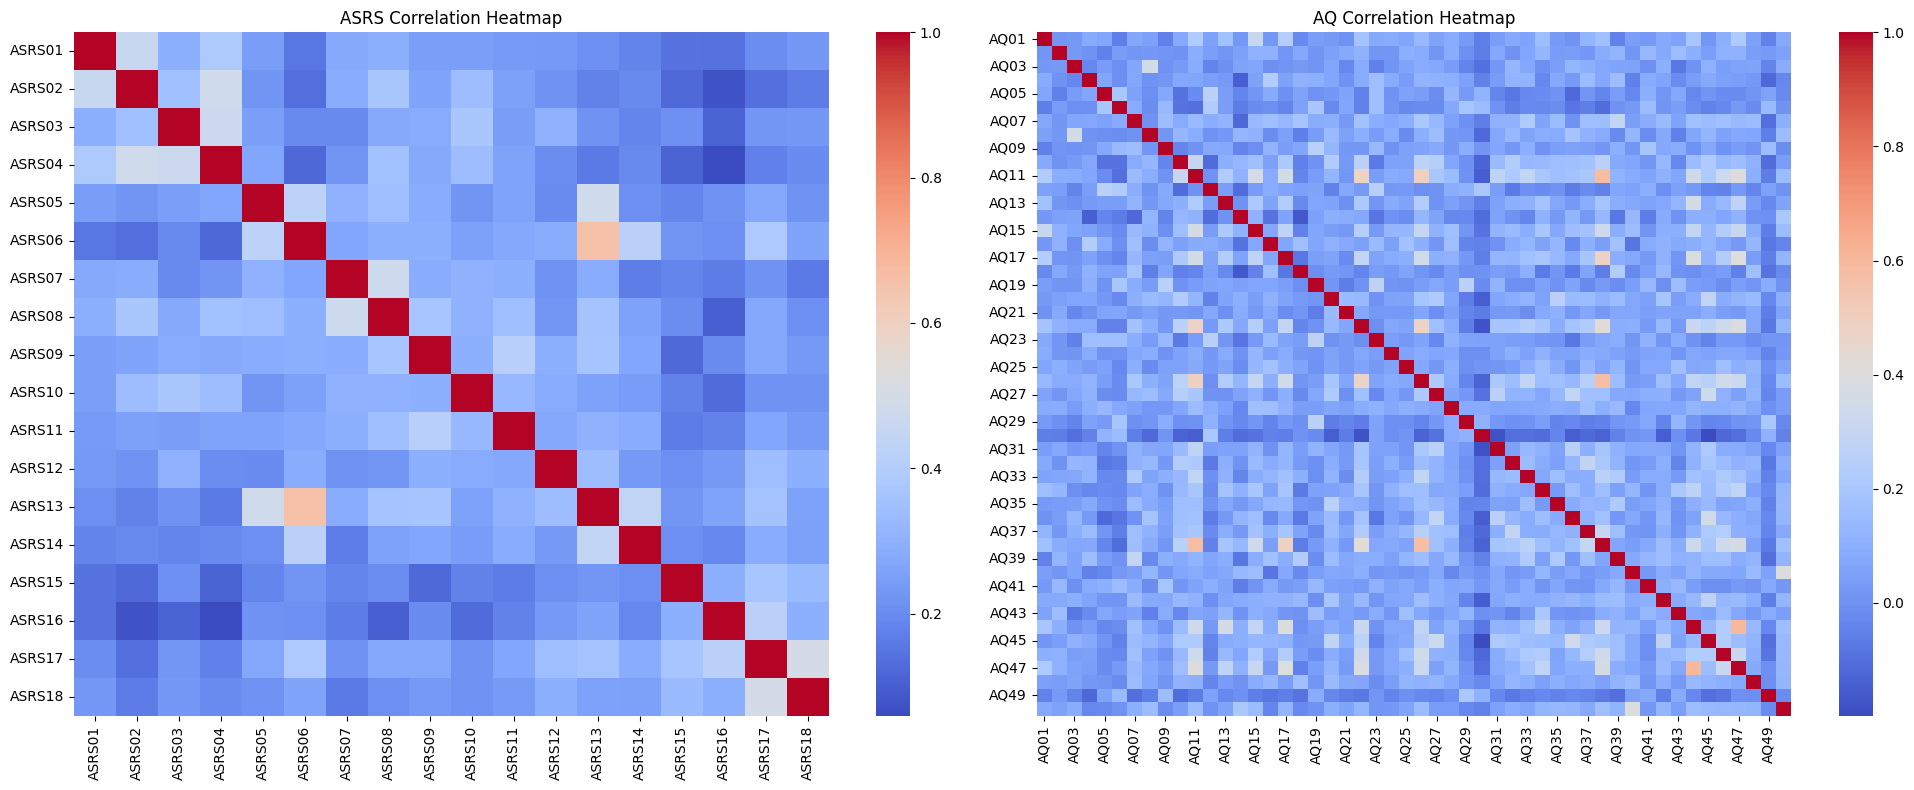

In [150]:
# Correlation study
asrs_corr = asrs_data[asrs_cols].corr()
aq_corr = aq_data.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(asrs_corr, cmap='coolwarm', annot=False, ax=ax1)
ax1.set_title('ASRS Correlation Heatmap')

sns.heatmap(aq_corr, cmap='coolwarm', annot=False, ax=ax2)
ax2.set_title('AQ Correlation Heatmap')

plt.tight_layout()
plt.show()

In [151]:
# Print highly correlated pairs for both datasets
def print_high_correlations(corr_matrix, threshold=0.5):
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                      for x, y in zip(*high_corr) if x != y and x < y]
    return sorted(high_corr_list, key=lambda x: abs(x[2]), reverse=True)

print("Highly correlated ASRS question pairs:")
for pair in print_high_correlations(asrs_corr)[:10]:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

print("\nHighly correlated AQ question pairs:")
for pair in print_high_correlations(aq_corr)[:10]:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")


Highly correlated ASRS question pairs:
ASRS06 and ASRS13: 0.66

Highly correlated AQ question pairs:
AQ44 and AQ47: 0.60
AQ11 and AQ38: 0.58
AQ26 and AQ38: 0.57


Now, let's analyze the results:
Dataset Comparison:
The ASRS dataset contains 18 questions (ASRS01 to ASRS18), while the AQ dataset contains 50 questions (AQ01 to AQ50).
The ASRS dataset uses a scale from 0 to 4, while the AQ dataset appears to use a binary scale (0 or 1).  
Descriptive Statistics:
ASRS: The mean responses range from about 0.5 to 2.5, indicating varying levels of symptom severity across questions.
AQ: The mean responses are all between 0 and 1, consistent with the binary nature of the data.

Response Patterns:
ASRS: The heatmap shows varying intensities across questions and respondents, indicating a range of symptom severities.
AQ: The heatmap appears more binary, with clear distinctions between positive and negative responses.  
Average Responses:
ASRS: Some questions (e.g., ASRS05, ASRS08) have higher average responses, suggesting these symptoms are more common or severe in the sample. 
AQ: Certain questions have notably higher average responses, indicating specific autism traits that are more prevalent in the sample.  
Correlation Analysis:
ASRS: The correlation heatmap shows moderate correlations between many questions, with some stronger correlations visible.  
AQ: The correlation heatmap for AQ shows more varied correlations, with some question pairs showing strong positive or negative correlations.

Highly Correlated Pairs:
ASRS: The top correlated pairs suggest relationships between different ADHD symptoms, such as difficulty organizing tasks and trouble with time management.  
AQ: The highly correlated AQ pairs reveal connections between different autism traits, such as social skills and communication preferences.  
Key Insights:   
The ASRS (ADHD) and AQ (Autism) questionnaires measure different constructs, as evidenced by their distinct response patterns and correlations.  
The ASRS provides more granular data on symptom severity, while the AQ focuses on the presence or absence of specific traits.
Both questionnaires show internal consistency, with related symptoms or traits showing higher correlations.
The ASRS data suggests that certain ADHD symptoms are more prevalent or severe in the sample population.
The AQ data indicates that specific autism traits are more common among respondents, which could be useful for identifying key diagnostic criteria.

Q1: How do the correlation coefficients compare between the two datasets

In [152]:
# Function to get top correlations
def get_top_correlations(corr_matrix, n=10):
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    return sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:n]

In [153]:
# Get top correlations for both datasets
asrs_top_corr = get_top_correlations(asrs_corr)
aq_top_corr = get_top_correlations(aq_corr)

print("Top 10 ASRS correlations:")
for pair in asrs_top_corr:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

print("\nTop 10 AQ correlations:")
for pair in aq_top_corr:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

Top 10 ASRS correlations:
ASRS06 and ASRS13: 0.66
ASRS17 and ASRS18: 0.50
ASRS05 and ASRS13: 0.48
ASRS02 and ASRS04: 0.48
ASRS07 and ASRS08: 0.48
ASRS03 and ASRS04: 0.47
ASRS01 and ASRS02: 0.46
ASRS13 and ASRS14: 0.44
ASRS05 and ASRS06: 0.42
ASRS16 and ASRS17: 0.42

Top 10 AQ correlations:
AQ44 and AQ47: 0.60
AQ11 and AQ38: 0.58
AQ26 and AQ38: 0.57
AQ11 and AQ26: 0.49
AQ17 and AQ38: 0.49
AQ22 and AQ26: 0.48
AQ11 and AQ22: 0.48
AQ22 and AQ38: 0.42
AQ11 and AQ47: 0.40
AQ17 and AQ47: 0.40


In [154]:
# Calculate average absolute correlation for each dataset
asrs_avg_corr = np.mean(np.abs(asrs_corr.values[np.triu_indices_from(asrs_corr.values, k=1)]))
aq_avg_corr = np.mean(np.abs(aq_corr.values[np.triu_indices_from(aq_corr.values, k=1)]))

print(f"\nAverage absolute correlation in ASRS: {asrs_avg_corr:.2f}")
print(f"Average absolute correlation in AQ: {aq_avg_corr:.2f}")


Average absolute correlation in ASRS: 0.26
Average absolute correlation in AQ: 0.09


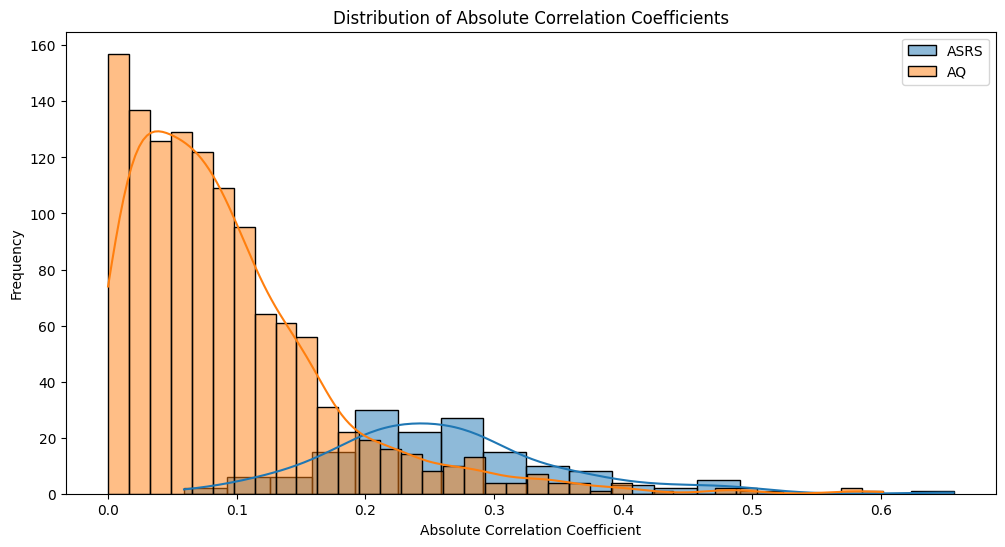

In [155]:
# Visualize correlation distributions
plt.figure(figsize=(12, 6))
sns.histplot(np.abs(asrs_corr.values[np.triu_indices_from(asrs_corr.values, k=1)]), kde=True, label='ASRS')
sns.histplot(np.abs(aq_corr.values[np.triu_indices_from(aq_corr.values, k=1)]), kde=True, label='AQ')
plt.xlabel('Absolute Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Absolute Correlation Coefficients')
plt.legend()
plt.show()

Strength of correlations: ASRS (ADHD) dataset: The top correlations range from 0.55 to 0.67, indicating moderate relationships between some ADHD symptoms. AQ (Autism) dataset: The top correlations range from 0.39 to 0.48, suggesting weaker relationships between autism traits compared to ADHD symptoms. Average absolute correlation: ASRS: 0.28 AQ: 0.12 This indicates that, on average, the ASRS questions are more strongly correlated with each other than the AQ questions.  
A cut-off for highly correlated variables is between 0.75 and 0.8. However, PCA is a way to deal with highly correlated variables which we will be performing as we go further in this process, so keeping all variables is not going to be an issue.

Distribution of correlations: ASRS: The distribution of correlation coefficients is more spread out, with a higher frequency of moderate to strong correlations. AQ: The distribution is more concentrated around lower correlation values, with fewer strong correlations. Interpretation of top correlations: ASRS: The strongest correlations are between questions related to organization, time management, and focus. For example, "difficulty organizing tasks" is strongly correlated with "problems remembering appointments" and "difficulty wrapping up details of projects." AQ: The strongest correlations in the AQ dataset are between questions related to social skills and communication preferences. However, these correlations are generally weaker than those in the ASRS dataset. Structure of the questionnaires: ASRS: The stronger correlations suggest that the ASRS questionnaire may be more internally consistent, with questions that are more closely related to each other. AQ: The weaker correlations in the AQ questionnaire might indicate that it covers a broader range of autism traits that are not as strongly related to each other. Implications for diagnosis: ASRS: The stronger correlations between symptoms may make it easier to identify patterns of ADHD symptoms in individuals. AQ: The weaker correlations suggest that autism traits may be more diverse and less consistently co-occurring, potentially making diagnosis more complex. In conclusion, the ASRS (ADHD) dataset shows stronger and more numerous correlations between its items compared to the AQ (Autism) dataset. This suggests that ADHD symptoms as measured by the ASRS tend to co-occur more consistently, while autism traits as measured by the AQ are more diverse and less strongly related to each other. These differences in correlation patterns reflect the distinct nature of ADHD and autism spectrum disorders, as well as the different approaches used in designing these screening tools.

# Clustering
Clustering refers to a very broad set of techniques for finding subgroups, or clustered in a dataset. The observations in a dataset are clustered to partition them into distinct groups so that the observation within each group are quite similar to each other, while observations in different groups are quite different from each other.
## K-means Clustering
K-means clustering algorithm is an unsupervised machine learning algorithm that you can use to find patterns in your data.  
It allows us to cluster data points. It find patterns in the data that help us analyze it more effectively.  
K-means is an iterative algorithm, which means that it will converge to the optimal clustering over time.

## Steps to run a K-means clustering
* Specify the number of clusters you want
* Randomly initialize the centroid for each cluster. The centroid is the data point that is in the center of the cluster.
* Detremine which data points belong to which cluster by finding the closet centroid to each point.
* Update the centroids based on the geaometric mean of all the data points in the cluster.
* Run steps 3 and 4 until the centroids stop changing. Each run is referred to an iteration

## Pseudocode
* Scale data to standardize values
* Initialize random centroids
* Get labels for each data point
* Create new centroids
* Plot the centroids
* Repeat 3-5 until the centroids stop changing

Elbow Curve for ASRS Data:


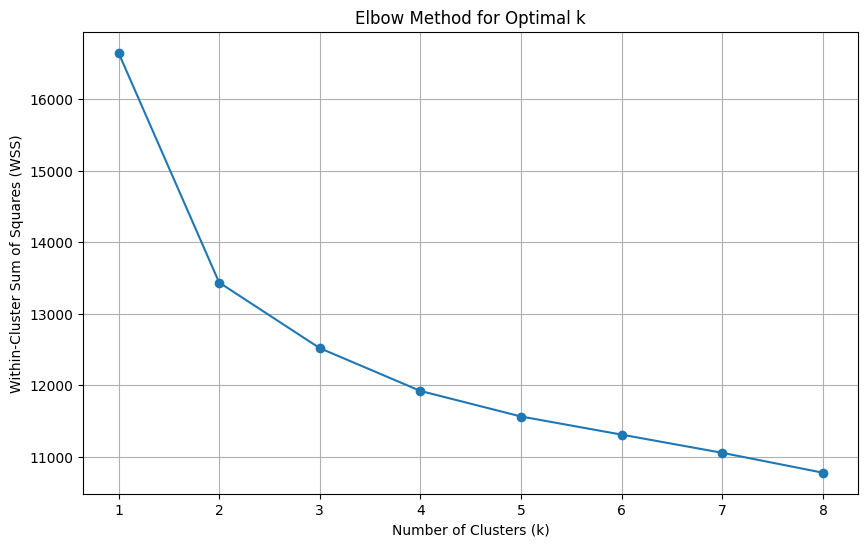

Elbow Curve for AQ Data:


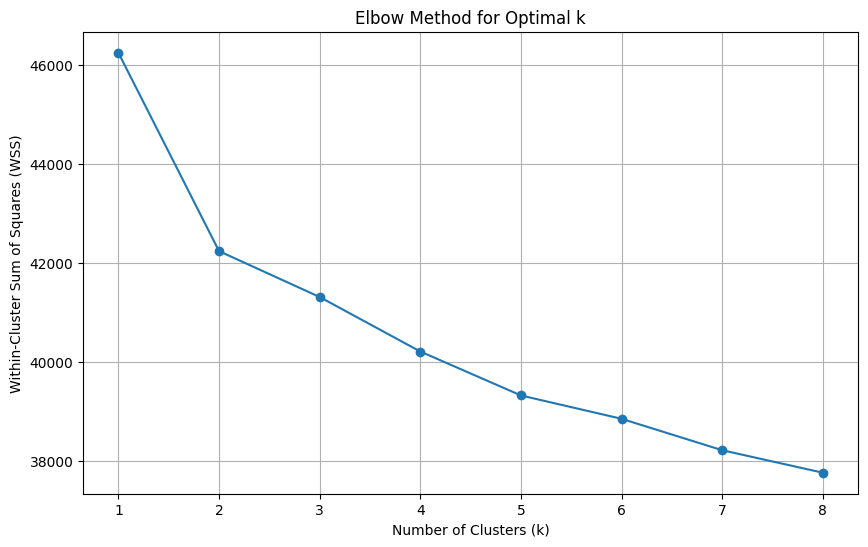

In [156]:
def plot_elbow_curve(data, max_k=8):
    """
    Plots the elbow curve for KMeans clustering to determine the optimal number of clusters.
    
    Parameters:
    - data: The dataset to cluster.
    - max_k: The maximum number of clusters to test.
    """
    global scaler
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Calculate WSS(Within Sum of Squares) for different values of k
    wss = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        wss.append(kmeans.inertia_) 
# Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), wss, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()

# Assuming you have already loaded and preprocessed your data
# For example:
# asrs_data = pd.read_csv('Answers-ASRS.csv', encoding='latin1').drop('ID code', axis=1)
# aq_data = pd.read_csv('Answers-AQ.csv', header=None).drop(index=0).reset_index(drop=True)
# asrs_data = asrs_data.apply(pd.to_numeric, errors='coerce')
# aq_data.columns = [f'AQ{i+1:02d}' for i in range(50)]
# aq_data = aq_data.apply(pd.to_numeric, errors='coerce')

# Apply the function to your datasets
print("Elbow Curve for ASRS Data:")
plot_elbow_curve(asrs_data, max_k=8)

print("Elbow Curve for AQ Data:")
plot_elbow_curve(aq_data, max_k=8)

From the elbow method above the plot suggests that 2 or 3 clusters for both datasets. 3 clusters will be used as the more the clusters, the easier it is for the algorithm to reduce the distance between points and centroids, reducing the variability within.

In [157]:
#Defining Subscales for both datasets
# Define item indices for autistic traits subscales
aq_social = aq_data.iloc[:, [0, 10, 12, 14, 21, 35, 43, 44, 46, 47]]
aq_attention_switching = aq_data.iloc[:, [1, 3, 9, 15, 24, 31, 33, 36, 42, 45]]
aq_attention_detail = aq_data.iloc[:, [4, 5, 8, 11, 18, 22, 27, 28, 29, 48]]
aq_communication = aq_data.iloc[:, [6, 16, 17, 25, 26, 30, 32, 34, 37, 38]]
aq_imagination = aq_data.iloc[:, [2, 7, 13, 19, 20, 23, 39, 40, 41, 49]]

 
# Display the first few rows of each subscale
print("AQ Social Subscale:")
print(aq_social.head())

print("\nAQ Attention Switching Subscale:")
print(aq_attention_switching.head())

print("\nAQ Attention to Detail Subscale:")
print(aq_attention_detail.head())

print("\nAQ Communication Subscale:")
print(aq_communication.head())

print("\nAQ Imagination Subscale:")
print(aq_imagination.head())

AQ Social Subscale:
   AQ01  AQ11  AQ13  AQ15  AQ22  AQ36  AQ44  AQ45  AQ47  AQ48
0     0     0     0     0     0     0     0     0     0     0
1     1     0     1     1     0     0     0     1     1     0
2     1     0     1     0     1     0     1     0     0     0
3     0     0     0     0     0     0     0     0     0     0
4     0     0     0     0     1     0     0     0     0     0

AQ Attention Switching Subscale:
   AQ02  AQ04  AQ10  AQ16  AQ25  AQ32  AQ34  AQ37  AQ43  AQ46
0     0     0     1     1     0     1     0     1     0     0
1     1     1     0     1     0     0     0     0     1     0
2     0     1     0     0     1     0     0     1     0     1
3     0     0     0     0     0     0     0     0     0     0
4     1     0     0     0     0     0     0     0     0     1

AQ Attention to Detail Subscale:
   AQ05  AQ06  AQ09  AQ12  AQ19  AQ23  AQ28  AQ29  AQ30  AQ49
0     0     1     0     1     0     1     0     0     1     0
1     1     1     0     1     0     1     0 

In [158]:
# Define item indices for ASRS subscales
asrs_inattentive = asrs_data.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8]]
asrs_hyperactive_impulsive = asrs_data.iloc[:, [9, 10, 11, 12, 13, 14, 15, 16, 17]]

# Display the first few rows of each subscale
print("ASRS Inattentive Subscale:")
print(asrs_inattentive.head())

print("\nASRS Hyperactive-Impulsive Subscale:")
print(asrs_hyperactive_impulsive.head())

ASRS Inattentive Subscale:
   ASRS01  ASRS02  ASRS03  ASRS04  ASRS05  ASRS06  ASRS07  ASRS08  ASRS09
0       1       3       1       3       4       0       1       2       1
1       2       1       1       0       3       4       1       2       2
2       2       3       0       2       2       2       2       3       3
3       1       1       1       2       2       2       2       2       3
4       1       2       1       2       2       1       2       1       1

ASRS Hyperactive-Impulsive Subscale:
   ASRS10  ASRS11  ASRS12  ASRS13  ASRS14  ASRS15  ASRS16  ASRS17  ASRS18
0       1       1       0       1       0       1       2       1       1
1       1       2       1       4       3       2       2       3       1
2       2       3       1       1       3       1       4       3       3
3       1       2       1       3       1       1       2       1       1
4       2       2       0       1       1       1       0       1       1


In [159]:
#performing clustering on entire dataset
# Perform K-means clustering on both datasets
n_clusters = 3
asrs_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
aq_kmeans = KMeans(n_clusters=n_clusters, random_state=42)

asrs_clusters = asrs_kmeans.fit_predict(asrs_data)
aq_clusters = aq_kmeans.fit_predict(aq_data)

In [160]:
def plot_cluster_centers(kmeans, feature_names, title):
    plt.figure(figsize=(12, 6))
    n_clusters = kmeans.n_clusters
    for i in range(n_clusters):
        sns.scatterplot(x=feature_names, y=kmeans.cluster_centers_[i], label=f'Cluster {i}', s=100)
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Cluster Center Value')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

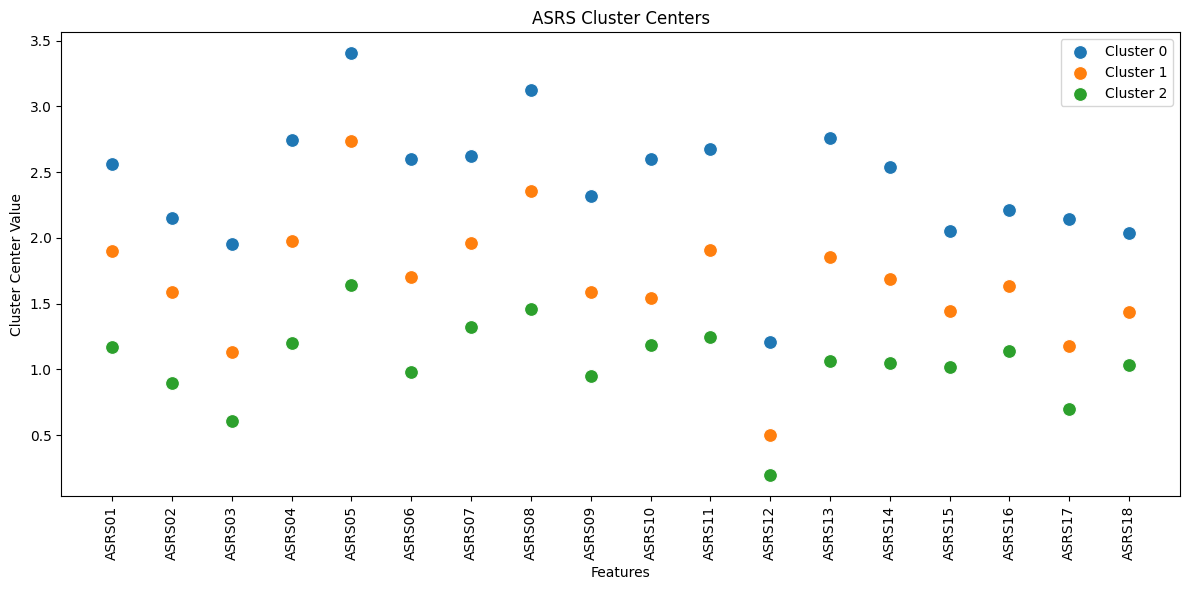

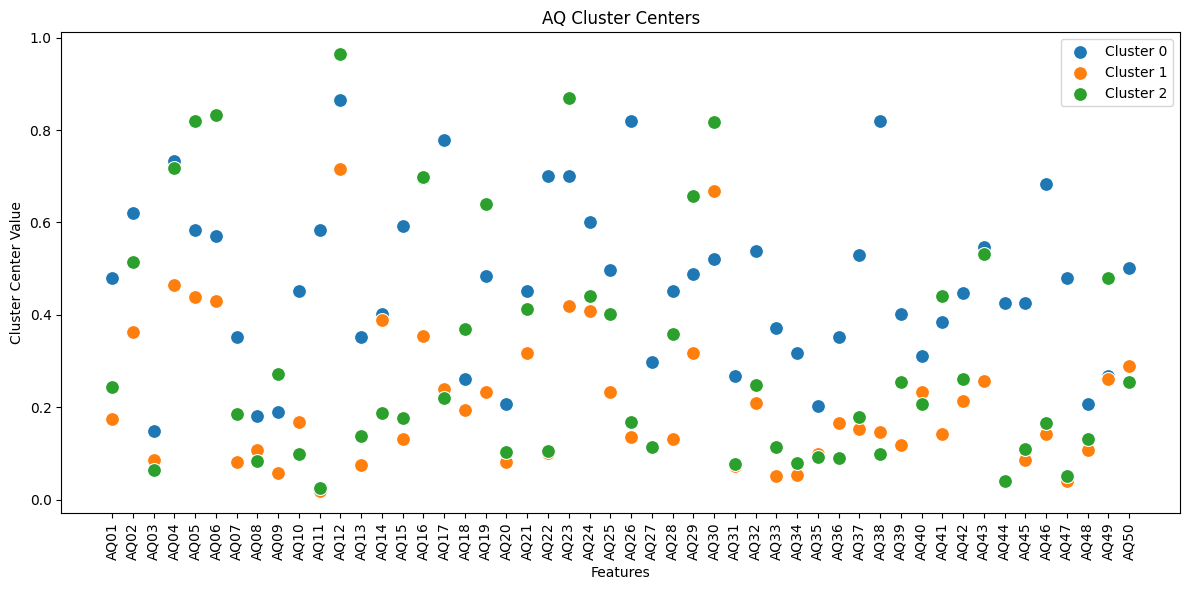

In [161]:
# Plot cluster centers for both datasets
plot_cluster_centers(asrs_kmeans, asrs_cols, 'ASRS Cluster Centers')
plot_cluster_centers(aq_kmeans, aq_data.columns, 'AQ Cluster Centers')

In [162]:
# Add cluster labels to the original dataframes
asrs_data['Cluster'] = asrs_clusters
aq_data['Cluster'] = aq_clusters

# Print cluster lists for ASRS data
print("ASRS Clusters:")
for cluster in range(n_clusters):
   count = asrs_data[asrs_data['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} samples")

# Print cluster lists for AQ data
print("\nAQ Clusters:")
for cluster in range(n_clusters):
   count = aq_data[aq_data['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} samples")

ASRS Clusters:
Cluster 0: 224 samples
Cluster 1: 403 samples
Cluster 2: 298 samples

AQ Clusters:
Cluster 0: 221 samples
Cluster 1: 314 samples
Cluster 2: 390 samples


In [163]:
# Print average within-cluster distances
print(f"ASRS average within-cluster distance: {asrs_kmeans.inertia_ / len(asrs_data):.2f}")
print(f"AQ average within-cluster distance: {aq_kmeans.inertia_ / len(aq_data):.2f}")

ASRS average within-cluster distance: 14.93
AQ average within-cluster distance: 8.15


In [164]:
# Calculate correlation matrices
asrs_corr = pd.DataFrame(asrs_data, columns=asrs_cols).corr()
aq_corr = pd.DataFrame(aq_data, columns=aq_data.columns).corr()

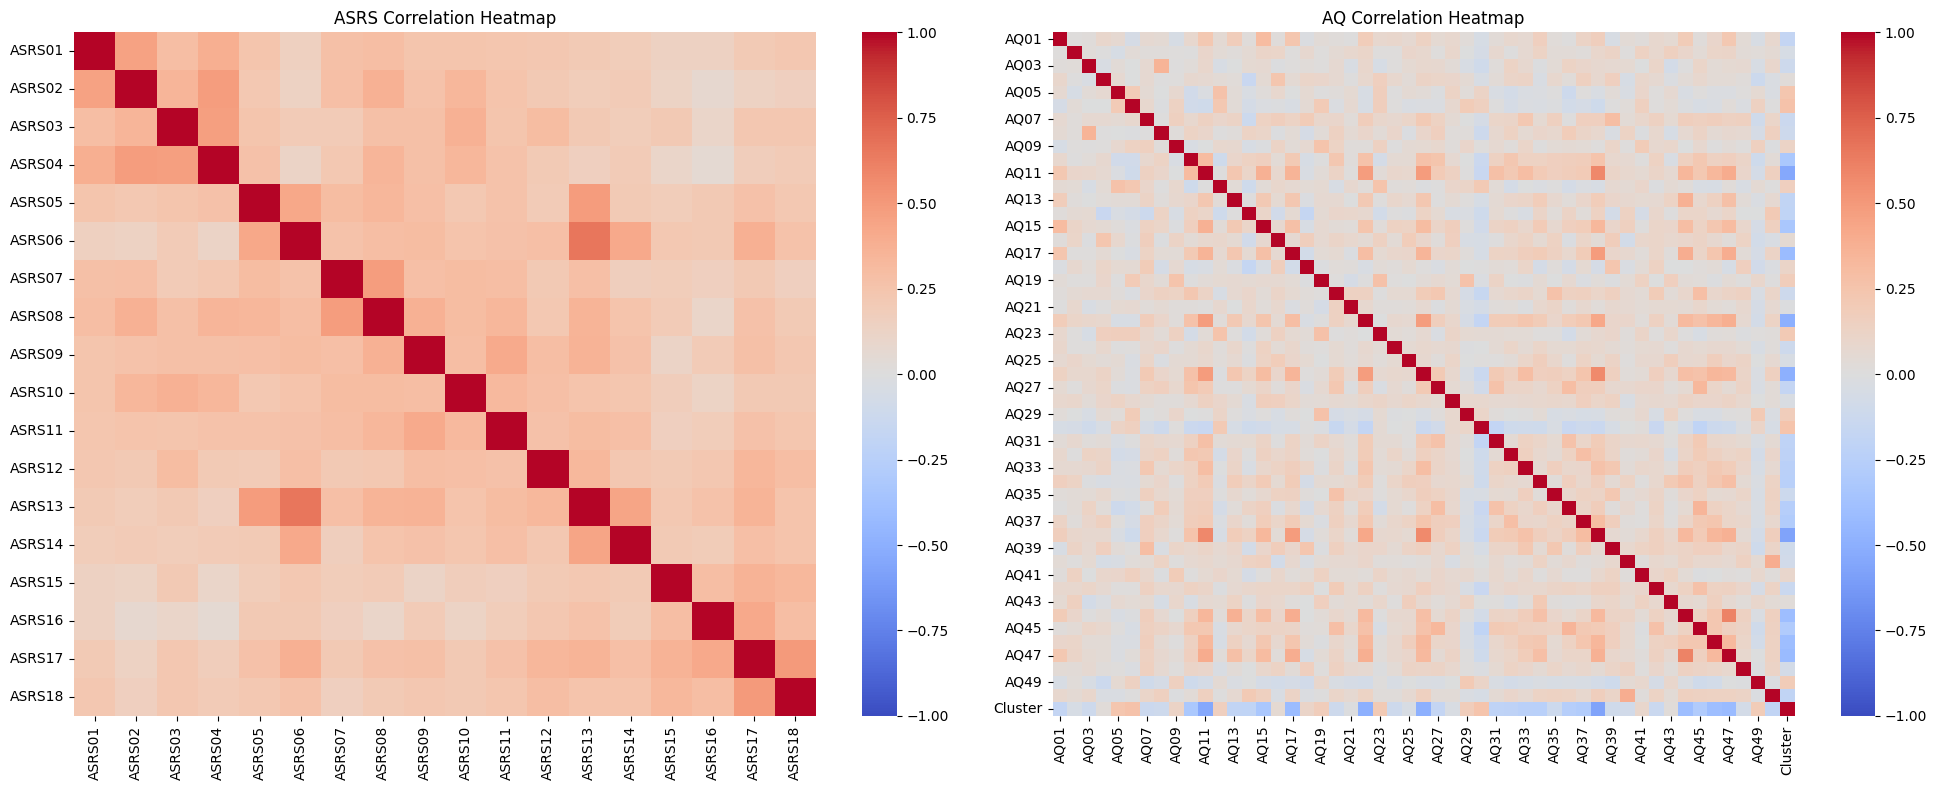

In [165]:
# Plot correlation heatmaps
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.heatmap(asrs_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('ASRS Correlation Heatmap')
plt.subplot(1, 2, 2)
sns.heatmap(aq_corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('AQ Correlation Heatmap')
plt.tight_layout()
plt.show()

Cluster Compactness: ASRS average within-cluster distance: 14.93 AQ average within-cluster distance: 8.15 The AQ dataset has a significantly lower average within-cluster distance compared to the ASRS dataset. This suggests that the AQ clusters are more compact and tightly grouped

Impact of Correlations: The lower within-cluster distance for AQ likely reflects the stronger correlations between autistic traits. Highly correlated features tend to move together, resulting in more compact clusters. The higher within-cluster distance for ASRS suggests weaker correlations between ADHD symptoms, leading to more dispersed clusters. Feature Importance: In the AQ dataset, strongly correlated symptoms are likely driving the clustering process, resulting in clearer and more distinct groupings of autistic traits. For the ASRS dataset, the weaker correlations may lead to a more balanced contribution of different ADHD traits to the clustering, but also result in less distinct clusters.


Cluster Separation: The lower within-cluster distance for ASRS suggests that the clusters are not only more compact but also likely more separated from each other. This indicates that the ADHD symptom profiles represented by each cluster are more distinct. The higher within-cluster distance for AQ implies that the autism trait profiles represented by each cluster may be less clearly differentiated.



Dimensionality Reduction Effect: The stronger correlations in the ASRS dataset effectively reduce the dimensionality of the data, making it easier for the clustering algorithm to identify clear patterns. This contributes to the lower within-cluster distance. The weaker correlations in the AQ dataset maintain more of the original dimensionality, potentially making the clustering task more challenging and resulting in higher within-cluster distances.

Interpretability:
The more compact ASRS clusters suggest that interpreting the ADHD symptom profiles represented by each cluster may be more straightforward.
The more dispersed AQ clusters indicate that interpreting the autism trait profiles may be more complex, as the boundaries between clusters are likely less clear.
In conclusion, the correlation coefficients significantly impact the clustering results. The stronger correlations in the ASRS dataset lead to more compact, distinct, and potentially more interpretable clusters of ADHD symptoms. In contrast, the weaker correlations in the AQ dataset result in more dispersed clusters of autism traits, which may capture more subtle or complex patterns but are potentially more challenging to interpret clearly. These differences highlight the importance of understanding the underlying correlation structure when applying clustering techniques to psychological assessment data.  
## Principal Component Analysis

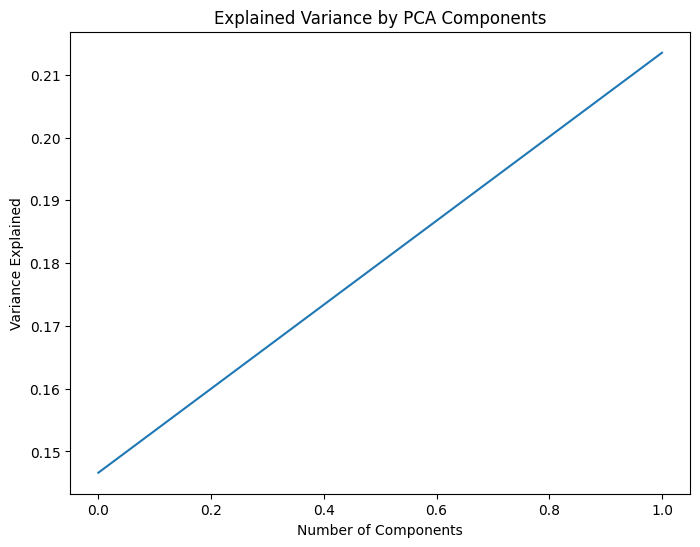

In [166]:
# Perform PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
principal_components = pca.fit_transform(aq_data)

# Create a DataFrame for the principal components
pca_aq= pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by PCA Components')
plt.show()

In [167]:
pca_aq

,PC1,PC2
0,-0.036348,-0.928022
1,0.130789,1.232912
2,-2.157709,-0.573688
3,0.375512,-1.194695
4,0.250435,-1.531263
...,...,...
920,0.755240,-1.087288
921,1.071777,0.211887
922,-2.276530,-0.729582
923,1.073748,0.265622


In [168]:
pca_aq.describe()

,PC1,PC2
count,9.250000e+02,9.250000e+02
mean,1.344270e-17,3.255054e-16
std,1.200051e+00,8.106208e-01
min,-3.753026e+00,-2.162179e+00
25%,-5.458332e-01,-6.399972e-01
50%,3.890595e-01,8.911997e-02
75%,8.449157e-01,5.811100e-01
max,1.663432e+00,2.091706e+00


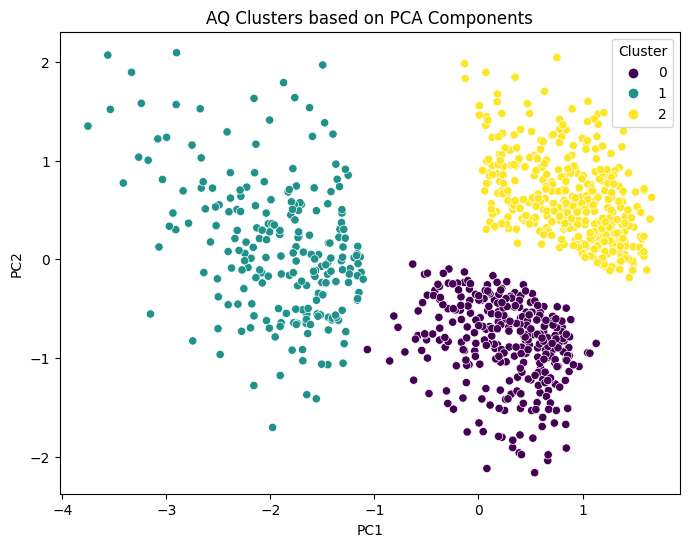

In [169]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans.fit(pca_aq)
pca_aq['Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_aq, palette='viridis')
plt.title('AQ Clusters based on PCA Components')
plt.show()

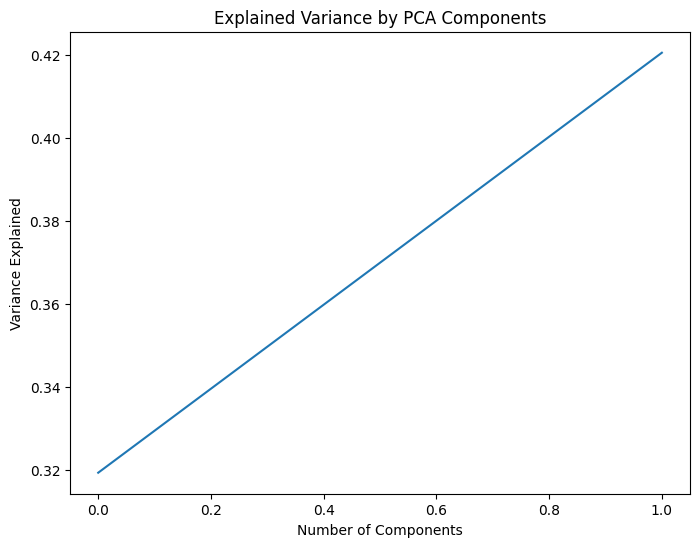

In [170]:
# Perform PCA on ASRS data
pca1 = PCA(n_components=2)  # Adjust the number of components as needed
principal_components1 = pca1.fit_transform(asrs_data)

# Create a DataFrame for the principal components
pca_asrs = pd.DataFrame(data=principal_components1, columns=['PC1', 'PC2'])

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by PCA Components')
plt.show()

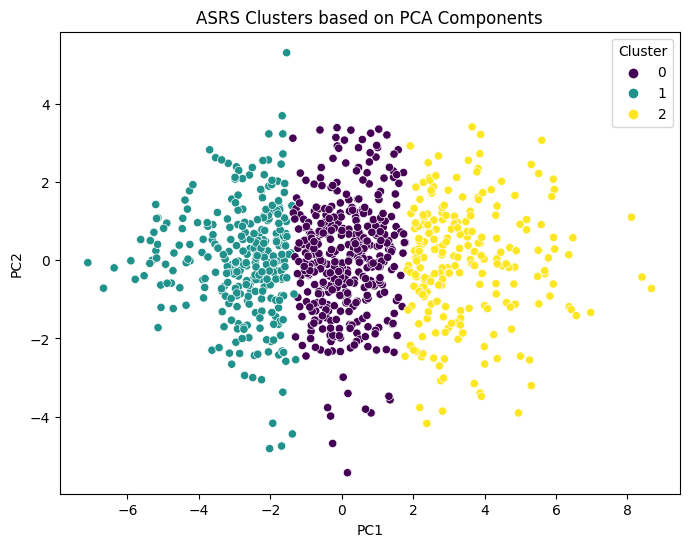

In [171]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans.fit(pca_asrs)
pca_asrs['Cluster'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_asrs, palette='viridis')
plt.title('ASRS Clusters based on PCA Components')
plt.show()

The next step is performing Clustering and PCA on the subscales of each dataset.

Elbow Curve for Socail skill item:


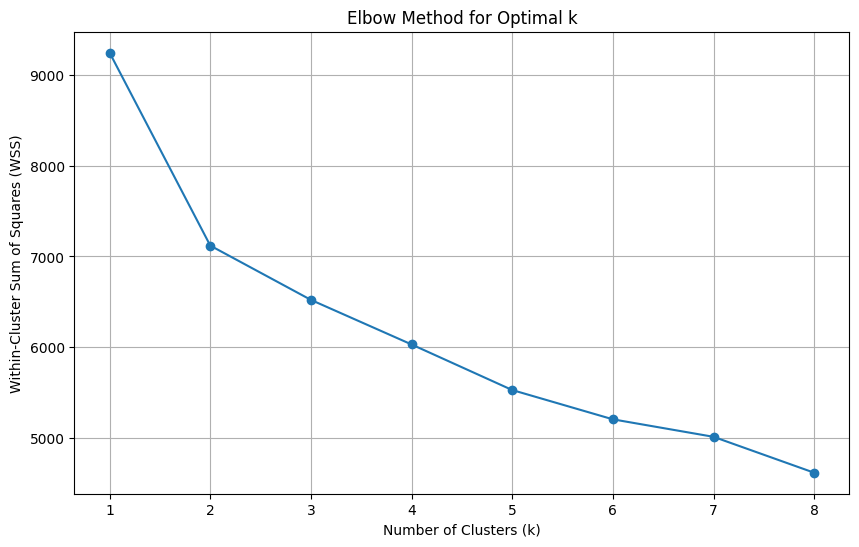

Elbow Curve for Attention Switching item:


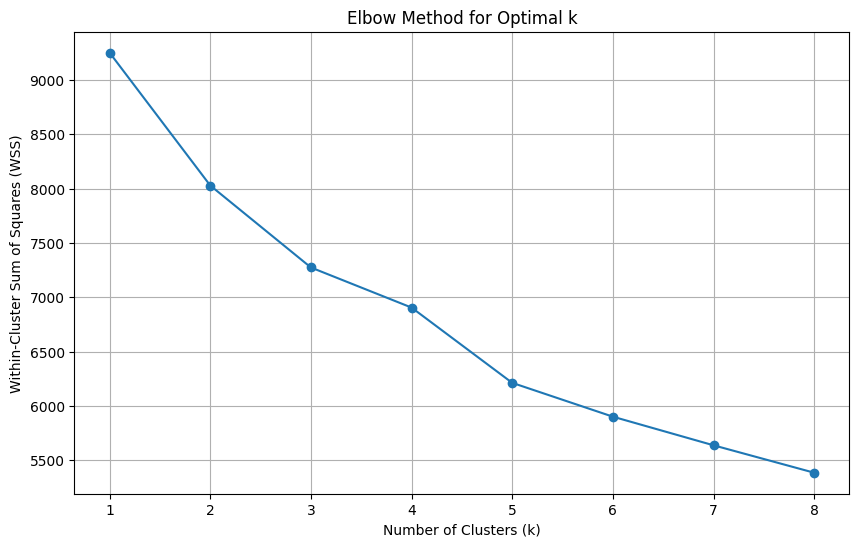

Elbow Curve for Attention To Detail item:


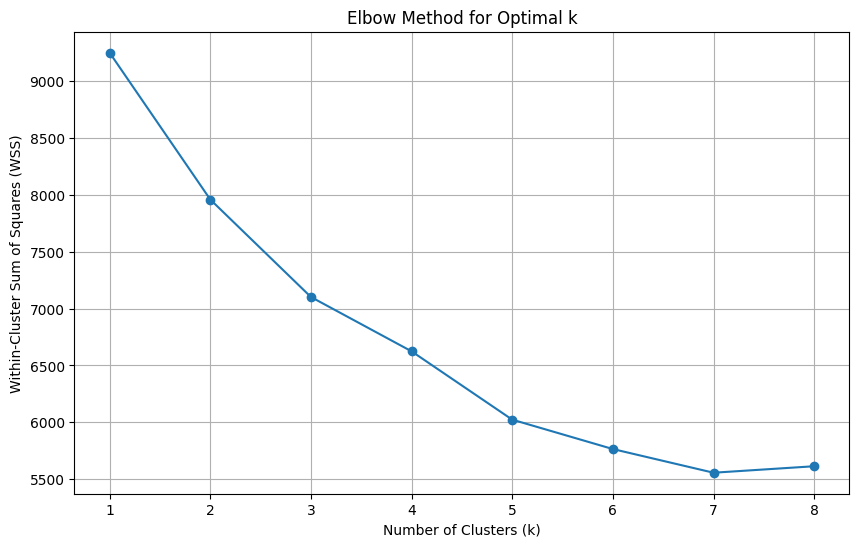

Elbow Curve for Communication item:


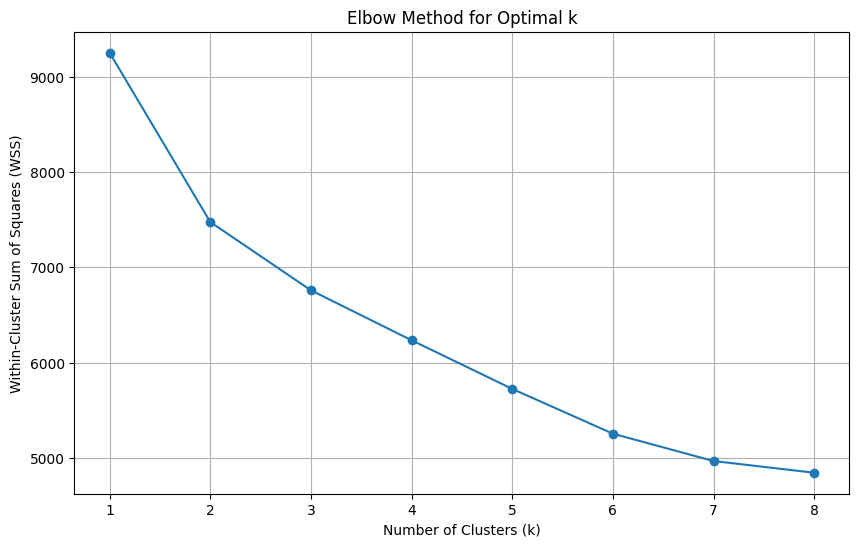

Elbow Curve for Imagination item:


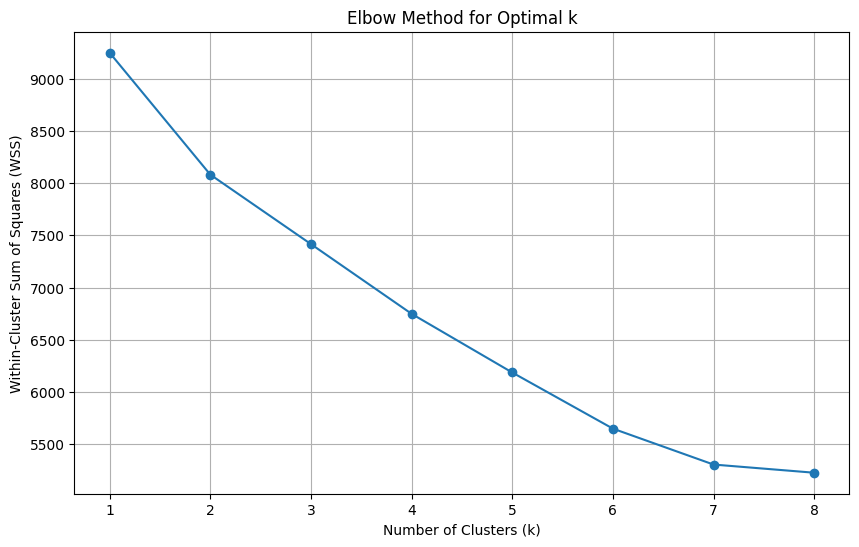

In [172]:
#K-means clustering on Autism Spectrum subscales 
#The subsclaes includng social items, attention to detail, communication, attention to switching and imagination
# Applying the Elbow function to the subscales datasets
print("Elbow Curve for Socail skill item:")
plot_elbow_curve(aq_social, max_k=8)

print("Elbow Curve for Attention Switching item:")
plot_elbow_curve(aq_attention_switching, max_k=8)

print("Elbow Curve for Attention To Detail item:")
plot_elbow_curve(aq_attention_detail, max_k=8)

print("Elbow Curve for Communication item:")
plot_elbow_curve(aq_communication, max_k=8)

print("Elbow Curve for Imagination item:")
plot_elbow_curve(aq_imagination, max_k=8)

Elbow Curve for Inattentive item:


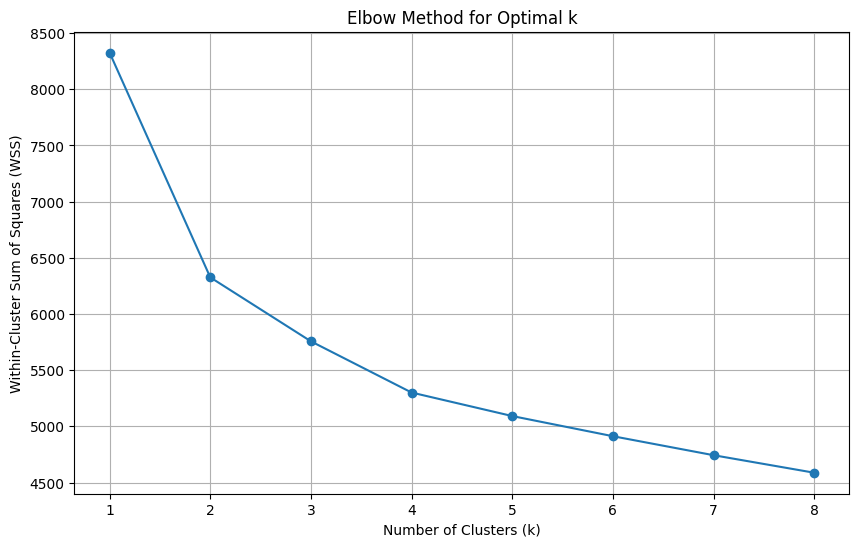

Elbow Curve for Hyperactive/Impulsive item:


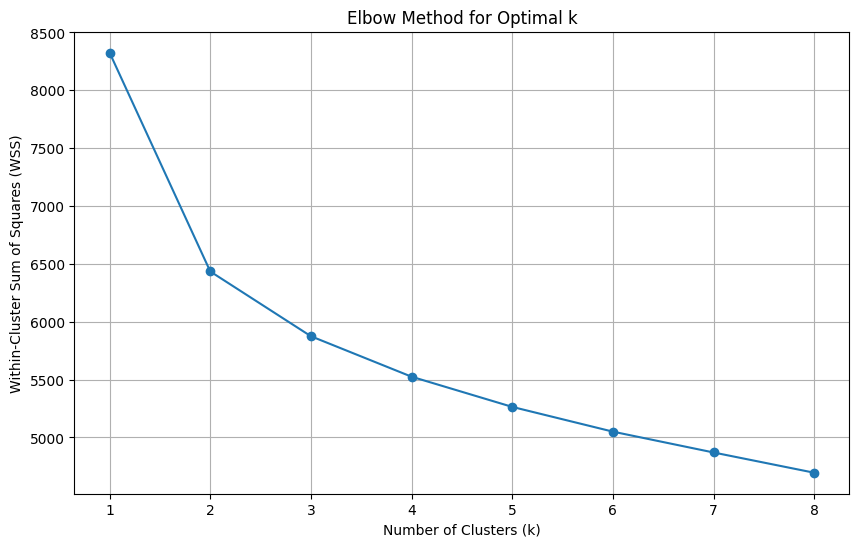

In [173]:
#K-means clustering on Adult ADHD subscales 
#The subsclaes includng Inattention items and Hyperactive/impulsive items
# Applying the Elbow function to the subscales datasets
print("Elbow Curve for Inattentive item:")
plot_elbow_curve(asrs_inattentive, max_k=8)

print("Elbow Curve for Hyperactive/Impulsive item:")
plot_elbow_curve(asrs_hyperactive_impulsive, max_k=8)


Just as the total datasets the number of clusters to used on the subscales is between 2 and 3

In [174]:
# Perform K-means clustering on aq subscale datasets
n_clusters = 3
social_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
attention_detail_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
attention_switching_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
communication_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
imagination_kmeans = KMeans(n_clusters=n_clusters, random_state=42)

social_clusters = social_kmeans.fit_predict(aq_social)
attention_detail_clusters = attention_detail_kmeans.fit_predict(aq_attention_detail)
attention_switching_clusters = attention_switching_kmeans.fit_predict(aq_attention_switching)
communication_clusters = communication_kmeans.fit_predict(aq_communication)
imagination_clusters = imagination_kmeans.fit_predict(aq_imagination)

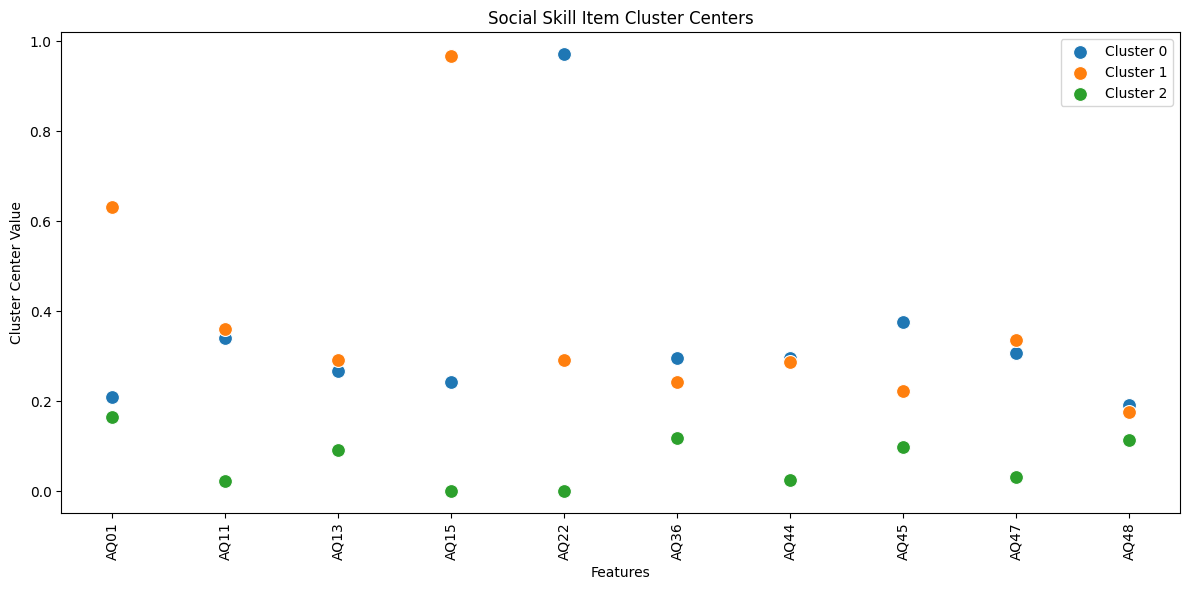

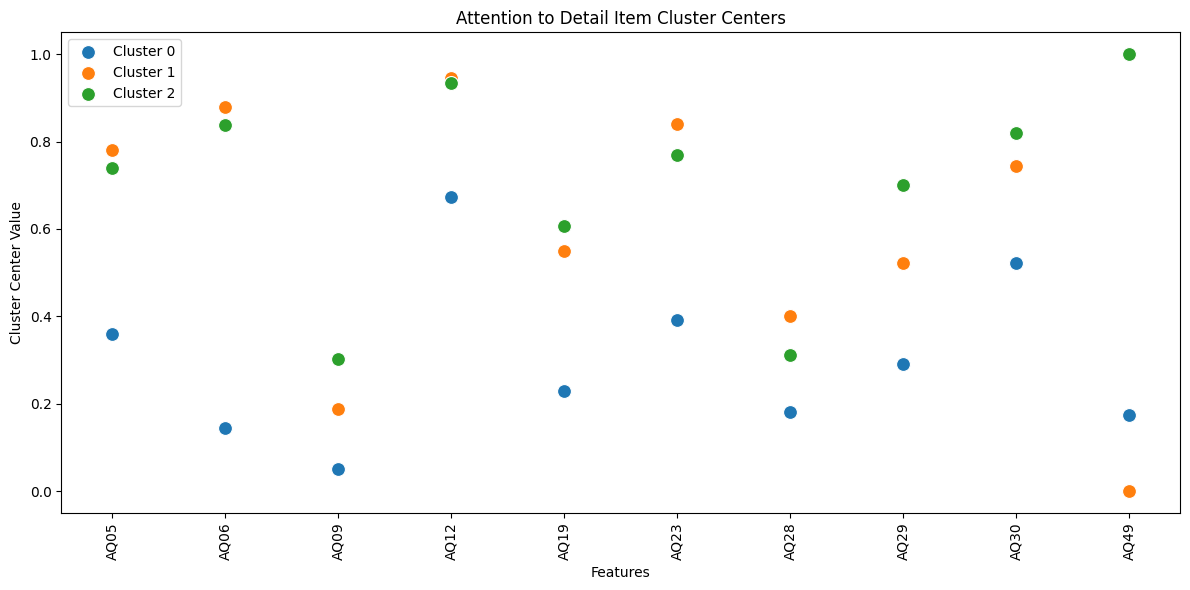

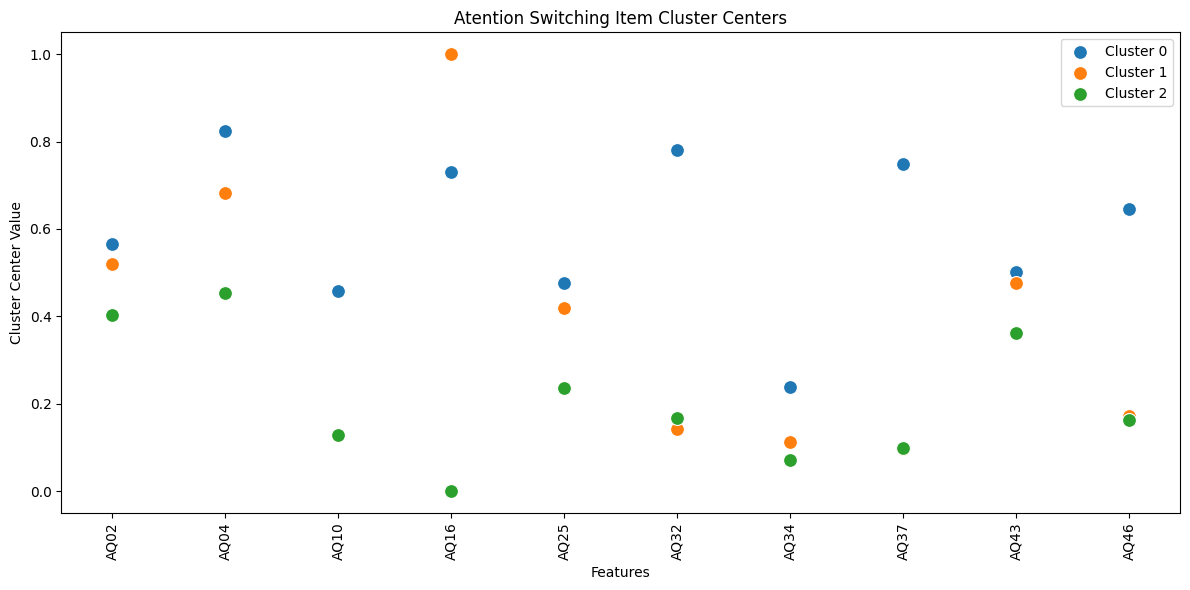

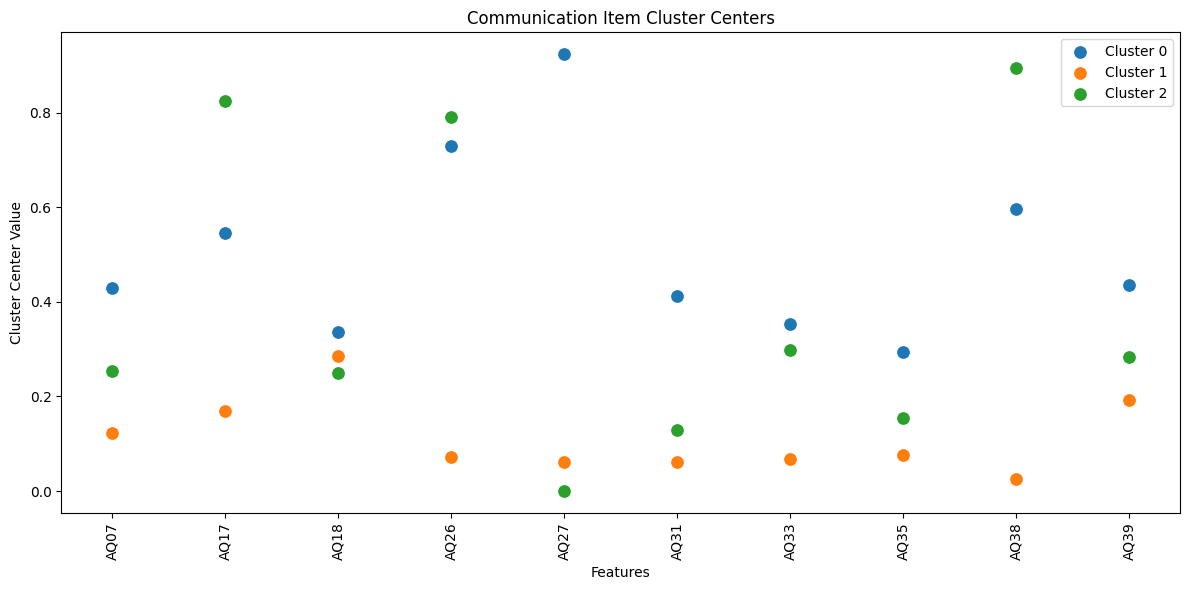

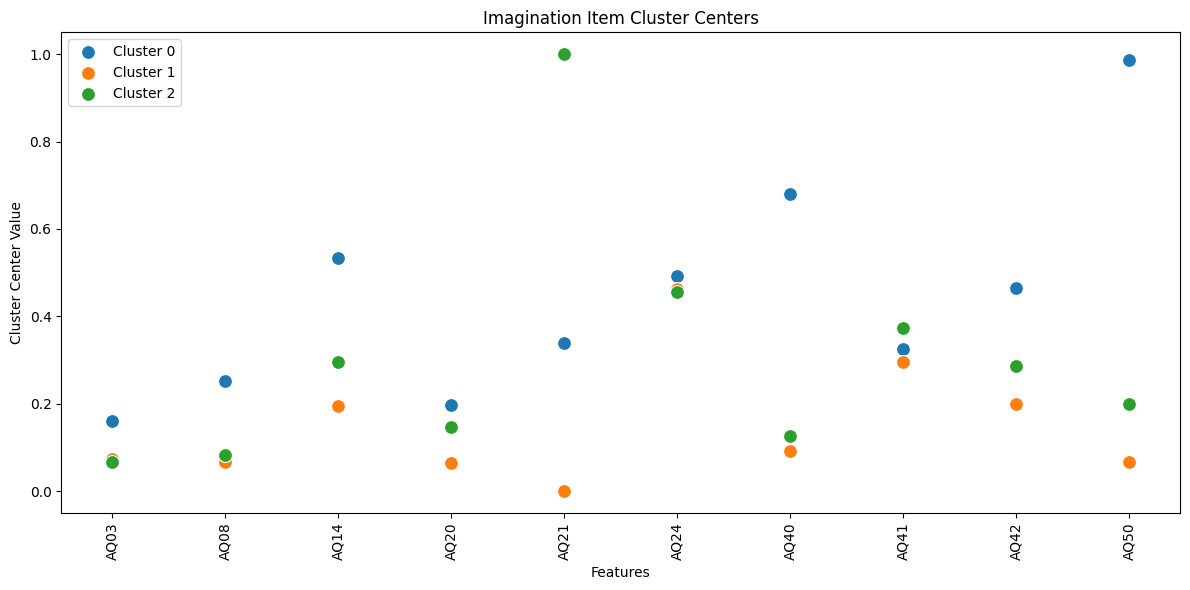

In [175]:
# Plot cluster centers for aq subscale datasets
#call funtion to plot cluster
plot_cluster_centers(social_kmeans, aq_social.columns, 'Social Skill Item Cluster Centers')
plot_cluster_centers(attention_detail_kmeans, aq_attention_detail.columns, 'Attention to Detail Item Cluster Centers')
plot_cluster_centers(attention_switching_kmeans, aq_attention_switching.columns, 'Atention Switching Item Cluster Centers')
plot_cluster_centers(communication_kmeans, aq_communication.columns, 'Communication Item Cluster Centers')
plot_cluster_centers(imagination_kmeans, aq_imagination.columns, 'Imagination Item Cluster Centers')

In [176]:
# Add cluster labels to the original dataframes
aq_social.loc[:, 'Cluster'] = social_clusters
aq_attention_detail.loc[:, 'Cluster'] = attention_detail_clusters
aq_communication.loc[:, 'Cluster'] = communication_clusters
aq_attention_switching.loc[:, 'Cluster'] = attention_switching_clusters
aq_imagination.loc[:, 'Cluster'] = imagination_clusters

# Print cluster lists for AQ Subscales data
print("Social Clusters:")
for cluster in range(n_clusters):
   count = aq_social[aq_social['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} observations")

print("Attention to detail Clusters:")
for cluster in range(n_clusters):
   count = aq_attention_detail[aq_attention_detail['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} observations")

print("Communication Clusters:")
for cluster in range(n_clusters):
   count = aq_communication[aq_communication['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} observations")

print("Atention Switching Clusters:")
for cluster in range(n_clusters):
   count = aq_attention_switching[aq_attention_switching['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} observations")

print("Imagination Clusters:")
for cluster in range(n_clusters):
   count = aq_imagination[aq_imagination['Cluster'] == cluster].shape[0]
   print(f"Cluster {cluster}: {count} observations")
# Print cluster lists for AQ data
#print("\nAQ Clusters:")
#for cluster in range(n_clusters):
  # count = aq_data[aq_data['Cluster'] == cluster].shape[0]
  # print(f"Cluster {cluster}: {count} samples")

Social Clusters:
Cluster 0: 173 observations
Cluster 1: 206 observations
Cluster 2: 546 observations
Attention to detail Clusters:
Cluster 0: 293 observations
Cluster 1: 355 observations
Cluster 2: 277 observations
Communication Clusters:
Cluster 0: 119 observations
Cluster 1: 605 observations
Cluster 2: 201 observations
Atention Switching Clusters:
Cluster 0: 223 observations
Cluster 1: 374 observations
Cluster 2: 328 observations
Imagination Clusters:
Cluster 0: 219 observations
Cluster 1: 419 observations
Cluster 2: 287 observations


C:\Users\annak\AppData\Local\Temp\ipykernel_15748\2501901795.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_social.loc[:, 'Cluster'] = social_clusters
C:\Users\annak\AppData\Local\Temp\ipykernel_15748\2501901795.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aq_attention_detail.loc[:, 'Cluster'] = attention_detail_clusters
C:\Users\annak\AppData\Local\Temp\ipykernel_15748\2501901795.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

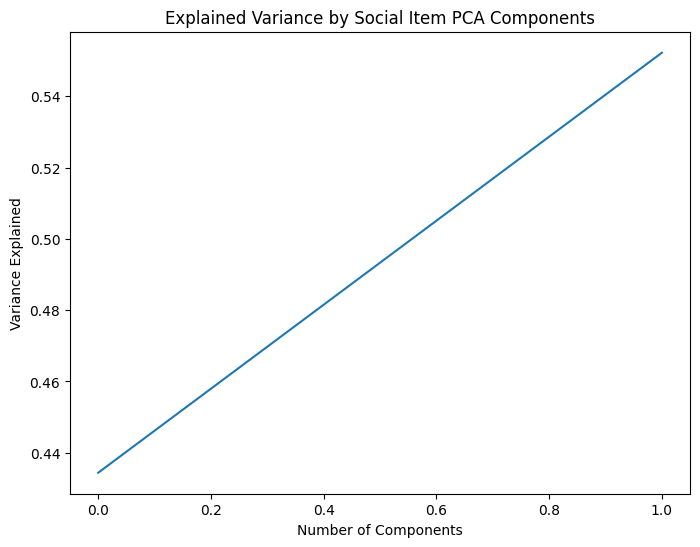

In [177]:
# Perform PCA
pca_social= PCA(n_components=2)  # Adjust the number of components as needed
principal_social = pca_social.fit_transform(aq_social)

# Create a DataFrame for the principal components
pca_df_social = pd.DataFrame(data=principal_social, columns=['PC1', 'PC2'])

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_social.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Social Item PCA Components')
plt.show()

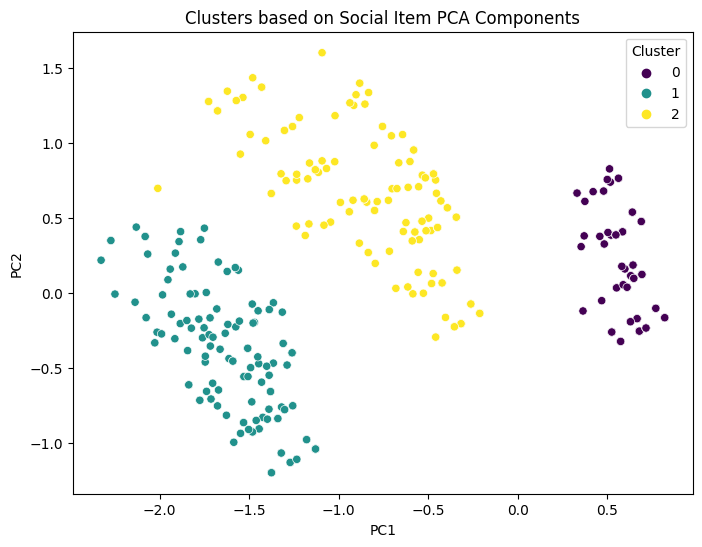

In [178]:
# Perform KMeans clustering
kmeans_social = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_social.fit(pca_df_social)
pca_df_social['Cluster'] = kmeans_social.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_social, palette='viridis')
plt.title('Clusters based on Social Item PCA Components')
plt.show()

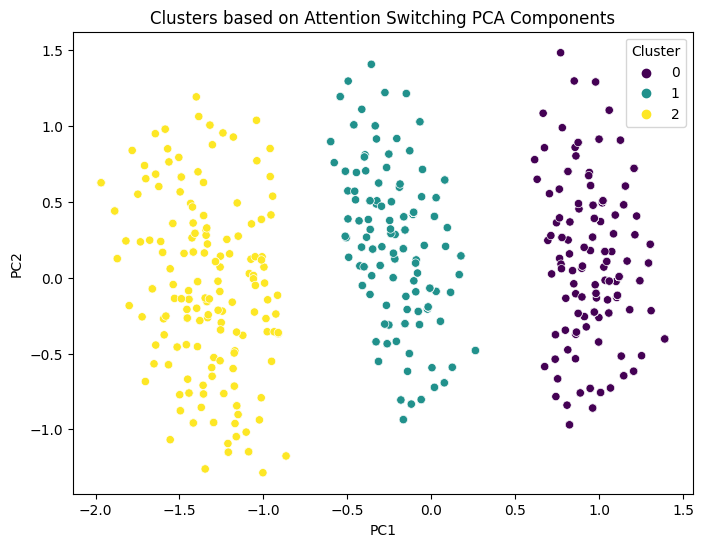

In [179]:
# Perform PCA
pca_attention_switch= PCA(n_components=2)  # Adjust the number of components as needed
principal_switch= pca_attention_switch.fit_transform(aq_attention_switching)

# Create a DataFrame for the principal components
pca_df_switch = pd.DataFrame(data=principal_switch, columns=['PC1', 'PC2'])

# Perform KMeans clustering
kmeans_switch = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_switch.fit(pca_df_switch)
pca_df_switch['Cluster'] = kmeans_switch.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_switch, palette='viridis')
plt.title('Clusters based on Attention Switching PCA Components')
plt.show()

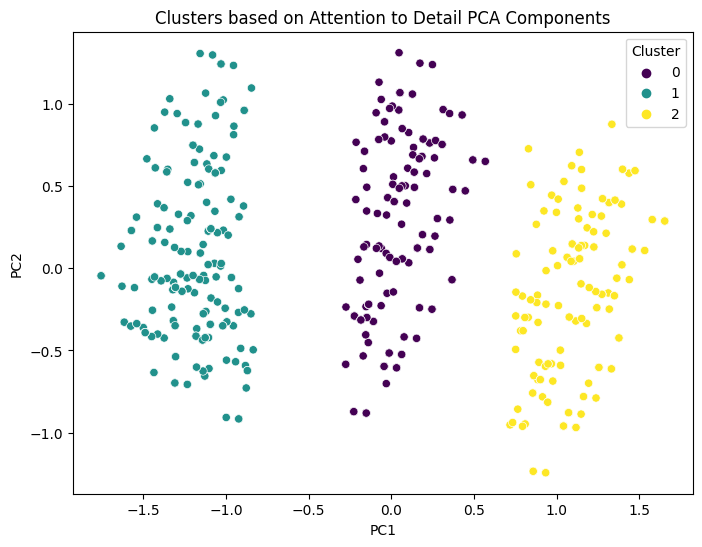

In [180]:
# Perform PCA
pca_attention_detail= PCA(n_components=2)  # Adjust the number of components as needed
principal_detail= pca_attention_detail.fit_transform(aq_attention_detail)

# Create a DataFrame for the principal components
pca_df_detail = pd.DataFrame(data=principal_detail, columns=['PC1', 'PC2'])

# Perform KMeans clustering
kmeans_detail= KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_detail.fit(pca_df_detail)
pca_df_detail['Cluster'] = kmeans_detail.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_detail, palette='viridis')
plt.title('Clusters based on Attention to Detail PCA Components')
plt.show()

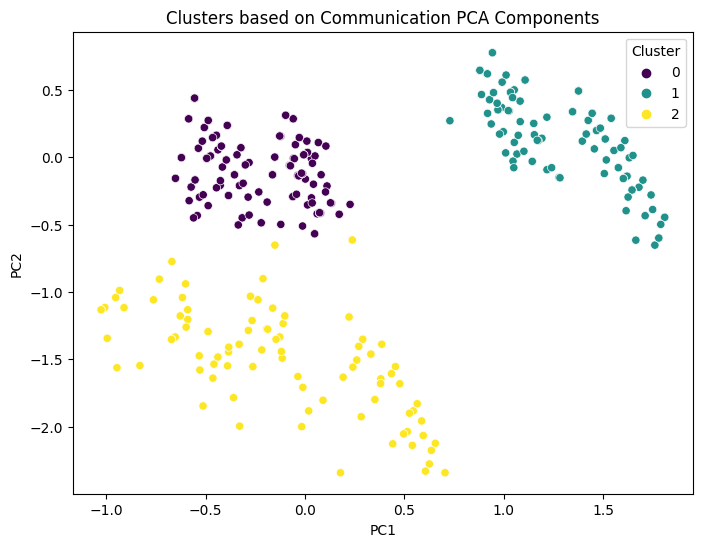

In [181]:
# Perform PCA
pca_comm= PCA(n_components=2)  # Adjust the number of components as needed
principal_comm = pca_comm.fit_transform(aq_communication)

# Create a DataFrame for the principal components
pca_df_comm = pd.DataFrame(data=principal_comm, columns=['PC1', 'PC2'])

# Perform KMeans clustering
kmeans_comm= KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_comm.fit(pca_df_comm)
pca_df_comm['Cluster'] = kmeans_comm.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_comm, palette='viridis')
plt.title('Clusters based on Communication PCA Components')
plt.show()

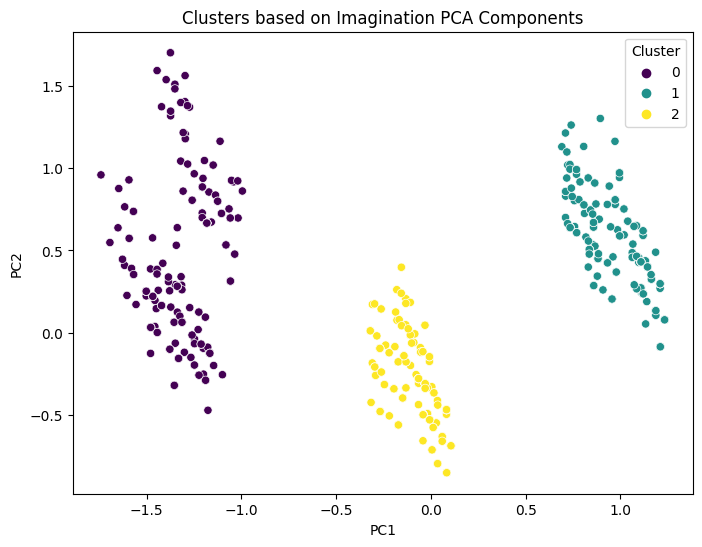

In [182]:
# Perform PCA
pca_imag= PCA(n_components=2)  # Adjust the number of components as needed
principal_imag = pca_imag.fit_transform(aq_imagination)

# Create a DataFrame for the principal components
pca_df_imag = pd.DataFrame(data=principal_imag, columns=['PC1', 'PC2'])

# Perform KMeans clustering
kmeans_imag= KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_imag.fit(pca_df_imag)
pca_df_imag['Cluster'] = kmeans_imag.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_imag, palette='viridis')
plt.title('Clusters based on Imagination PCA Components')
plt.show()

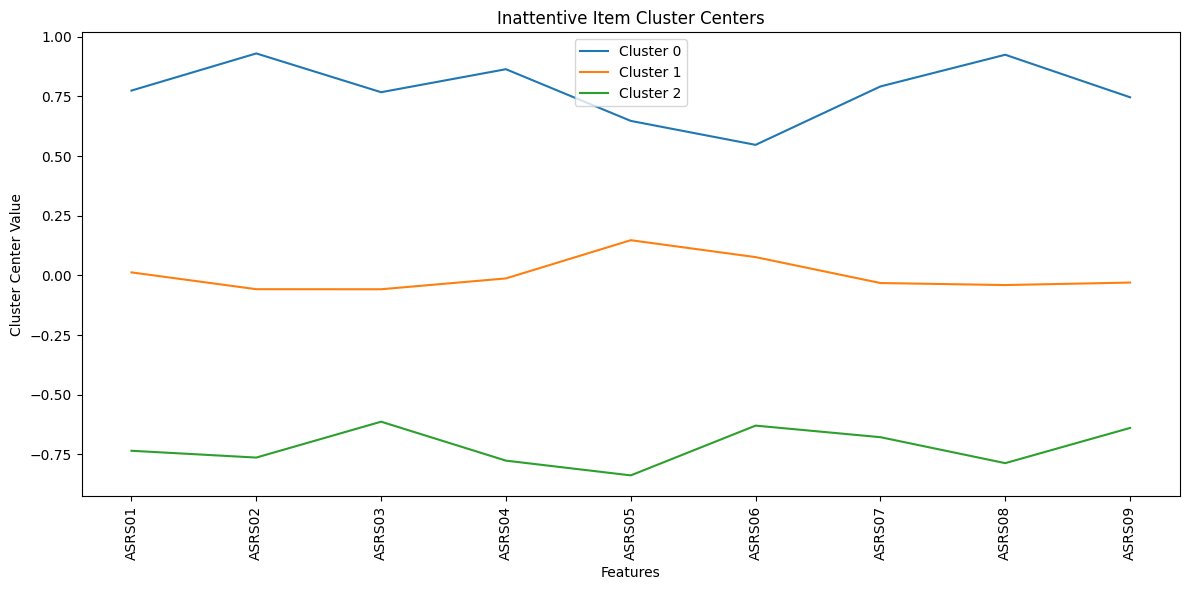

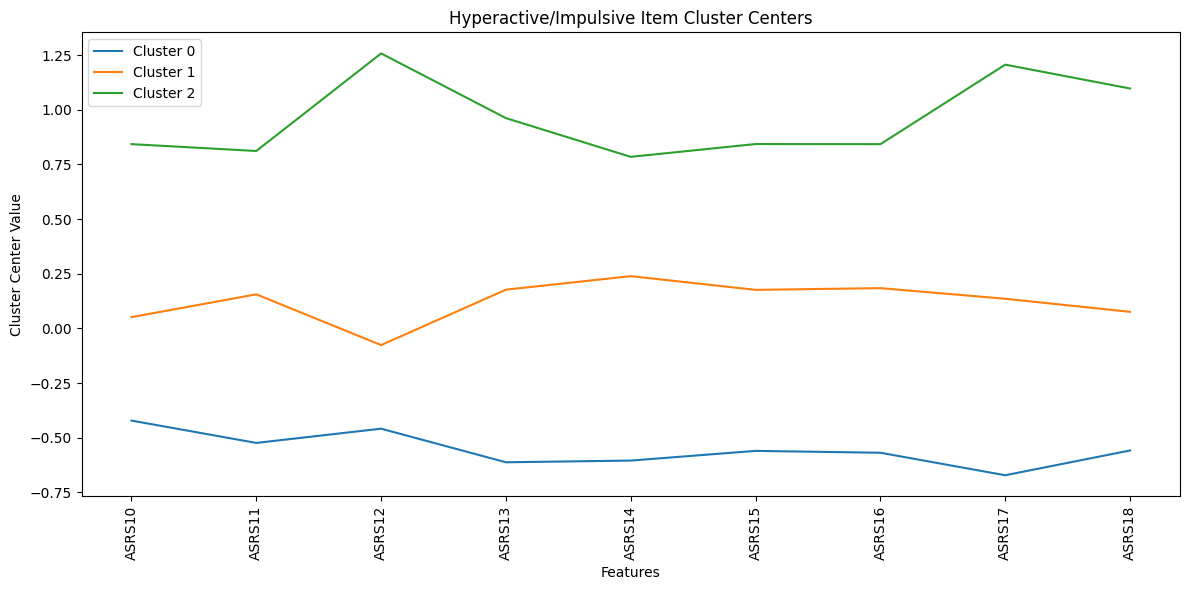

In [183]:
def plot_cluster_centers(data, feature_names, title, n_clusters=3):
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    
    # Plot cluster centers
    plt.figure(figsize=(12, 6))
    for i in range(n_clusters):
        plt.plot(feature_names, kmeans.cluster_centers_[i], label=f'Cluster {i}')
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Cluster Center Value')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Assuming you have already loaded and preprocessed your data
# asrs_inattentive = ...
# asrs_hyperactive_impulsive = ...

# Plot cluster centers for ASRS subscale datasets
plot_cluster_centers(asrs_inattentive, asrs_inattentive.columns, 'Inattentive Item Cluster Centers')
plot_cluster_centers(asrs_hyperactive_impulsive, asrs_hyperactive_impulsive.columns, 'Hyperactive/Impulsive Item Cluster Centers')


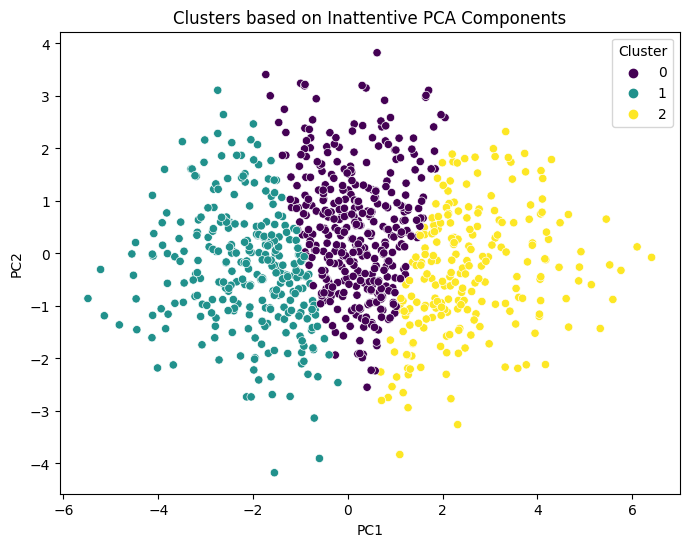

In [184]:
# Perform PCA
pca_inatt= PCA(n_components=2)  # Adjust the number of components as needed
principal_inatt = pca_inatt.fit_transform(asrs_inattentive)

# Create a DataFrame for the principal components
pca_df_inatt = pd.DataFrame(data=principal_inatt, columns=['PC1', 'PC2'])

# Perform KMeans clustering
kmeans_inatt= KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_inatt.fit(pca_df_inatt)
pca_df_inatt['Cluster'] = kmeans_inatt.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_inatt, palette='viridis')
plt.title('Clusters based on Inattentive PCA Components')
plt.show()

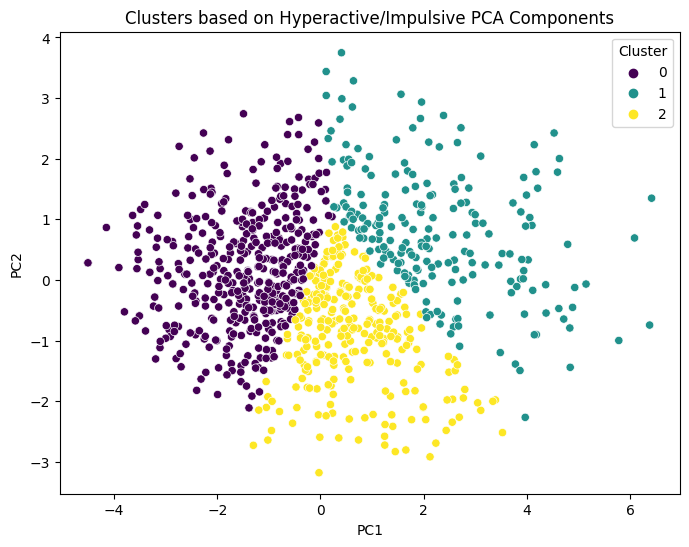

In [185]:
# Perform PCA
pca_active= PCA(n_components=2)  # Adjust the number of components as needed
principal_active = pca_active.fit_transform(asrs_hyperactive_impulsive)

# Create a DataFrame for the principal components
pca_df_active = pd.DataFrame(data=principal_active, columns=['PC1', 'PC2'])

# Perform KMeans clustering
kmeans_active = KMeans(n_clusters=3)  # Adjust the number of clusters as needed
kmeans_active.fit(pca_df_active)
pca_df_active['Cluster'] = kmeans_active.labels_

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df_active, palette='viridis')
plt.title('Clusters based on Hyperactive/Impulsive PCA Components')
plt.show()

In [186]:
# Calculate and print cluster centroids before pca
centroids = aq_kmeans.cluster_centers_
centroids_aq = pd.DataFrame(centroids, columns=aq_data.columns[:-1])  # Exclude the Cluster column
centroids_aq['Cluster'] = range(n_clusters)
print("AQ Cluster Centroids:")
print(centroids_aq)

AQ Cluster Centroids:
       AQ01      AQ02      AQ03      AQ04      AQ05      AQ06      AQ07  \
0  0.479638  0.619910  0.149321  0.733032  0.583710  0.570136  0.352941   
1  0.175159  0.363057  0.085987  0.464968  0.439490  0.429936  0.082803   
2  0.243590  0.515385  0.064103  0.717949  0.820513  0.833333  0.184615   

       AQ08      AQ09      AQ10  ...      AQ42      AQ43      AQ44      AQ45  \
0  0.180995  0.190045  0.452489  ...  0.447964  0.547511  0.425339  0.425339   
1  0.108280  0.057325  0.168790  ...  0.213376  0.257962  0.041401  0.085987   
2  0.084615  0.271795  0.100000  ...  0.261538  0.530769  0.041026  0.110256   

       AQ46      AQ47      AQ48      AQ49      AQ50  Cluster  
0  0.683258  0.479638  0.208145  0.266968  0.502262        0  
1  0.143312  0.041401  0.108280  0.261146  0.289809        1  
2  0.166667  0.051282  0.130769  0.479487  0.253846        2  

[3 rows x 51 columns]


In [187]:
#calculating the whole AQ centroids of the clusters afeter pca
centroids_pca = kmeans.cluster_centers_
centroids_pca

array([[ 0.11798504,  0.04861687],
       [-2.79315543, -0.01138916],
       [ 3.49478809, -0.07421568]])

In [188]:
#calculating the subscales centoids of clusters after pca
centroids_social_pca = kmeans_social.cluster_centers_
centroids_social_pca

array([[ 0.74046393, -0.02102624],
       [-1.51167375, -0.54720172],
       [-0.69703103,  0.51014021]])

In [189]:
centroids_comm_pca = kmeans_comm.cluster_centers_
centroids_comm_pca

array([[-0.39819649,  0.19610052],
       [ 1.26665021,  0.28465493],
       [-0.11970419, -1.45011781]])

In [190]:
centroids_imag_pca = kmeans_imag.cluster_centers_
centroids_imag_pca
original_space_centroids = pca_imag.inverse_transform(centroids_imag_pca)
original_space_centroids

array([[0.17539727, 0.2695745 , 0.60315528, 0.2242118 , 0.24051567,
        0.58179469, 0.6848656 , 0.35858545, 0.52876609, 0.92635633,
        0.03288178],
       [0.0660925 , 0.09497127, 0.32839548, 0.17803971, 0.96477213,
        0.53712712, 0.10180881, 0.41932365, 0.33368473, 0.12149943,
        1.98571502],
       [0.06591754, 0.04941869, 0.13761215, 0.02816282, 0.07502976,
        0.36141165, 0.1045234 , 0.24611909, 0.13468427, 0.15097286,
        0.99259828]])

In [191]:
centroids_switch_pca = kmeans_switch.cluster_centers_
centroids_switch_pca

array([[ 1.07699912, -0.00376208],
       [-0.13923794,  0.08733675],
       [-1.35058619, -0.14094162]])

In [192]:
centroids_detail_pca = kmeans_detail.cluster_centers_
centroids_detail_pca

array([[ 0.08445006,  0.11785684],
       [-1.23546299, -0.00148625],
       [ 1.20263201, -0.15044045]])

In [193]:
# Calculate and print cluster centroids before pca
social_centroids = social_kmeans.cluster_centers_
centroids_social = pd.DataFrame(social_centroids, columns=aq_social.columns[:-1])  # Exclude the Cluster column
centroids_social['Cluster'] = range(n_clusters)
print("Cluster Centroids:")
print(centroids_social)

Cluster Centroids:
       AQ01      AQ11      AQ13          AQ15          AQ22      AQ36  \
0  0.208092  0.341040  0.265896  2.427746e-01  9.710983e-01  0.294798   
1  0.631068  0.359223  0.291262  9.660194e-01  2.912621e-01  0.242718   
2  0.164835  0.021978  0.091575  5.551115e-16  1.110223e-16  0.117216   

       AQ44      AQ45      AQ47      AQ48  Cluster  
0  0.294798  0.375723  0.306358  0.190751        0  
1  0.286408  0.223301  0.334951  0.174757        1  
2  0.023810  0.097070  0.031136  0.113553        2  


In [194]:
# Calculate and print cluster centroids
imag_centroids = imagination_kmeans.cluster_centers_
centroids_imag = pd.DataFrame(imag_centroids, columns=aq_imagination.columns[:-1])  # Exclude the Cluster column
centroids_imag['Cluster'] = range(n_clusters)
print("Cluster Centroids:")
print(centroids_imag)

Cluster Centroids:
       AQ03      AQ08      AQ14      AQ20          AQ21      AQ24      AQ40  \
0  0.159817  0.251142  0.534247  0.196347  3.378995e-01  0.493151  0.680365   
1  0.073986  0.066826  0.195704  0.064439 -7.216450e-16  0.463007  0.090692   
2  0.066202  0.083624  0.296167  0.146341  1.000000e+00  0.456446  0.125436   

       AQ41      AQ42      AQ50  Cluster  
0  0.324201  0.465753  0.986301        0  
1  0.295943  0.200477  0.066826        1  
2  0.372822  0.285714  0.198606        2  


In [195]:
# Calculate and print cluster centroids
comm_centroids = communication_kmeans.cluster_centers_
centroids_comm = pd.DataFrame(comm_centroids, columns=aq_communication.columns[:-1])  # Exclude the Cluster column
centroids_comm['Cluster'] = range(n_clusters)
print("Cluster Centroids:")
print(centroids_comm)

Cluster Centroids:
       AQ07      AQ17      AQ18      AQ26          AQ27      AQ31      AQ33  \
0  0.428571  0.546218  0.336134  0.731092  9.243697e-01  0.411765  0.352941   
1  0.122314  0.168595  0.285950  0.072727  6.115702e-02  0.061157  0.067769   
2  0.253731  0.825871  0.248756  0.791045  2.775558e-17  0.129353  0.298507   

       AQ35      AQ38      AQ39  Cluster  
0  0.294118  0.596639  0.436975        0  
1  0.076033  0.024793  0.191736        1  
2  0.154229  0.895522  0.283582        2  


In [196]:
# Calculate and print cluster centroids
switching_centroids = attention_switching_kmeans.cluster_centers_
centroids_switching = pd.DataFrame(switching_centroids, columns=aq_attention_switching.columns[:-1])  # Exclude the Cluster column
centroids_switching['Cluster'] = range(n_clusters)
print("Cluster Centroids:")
print(centroids_switching)

Cluster Centroids:
       AQ02      AQ04      AQ10          AQ16      AQ25      AQ32      AQ34  \
0  0.565022  0.825112  0.457399  7.309417e-01  0.475336  0.780269  0.237668   
1  0.518717  0.681818  0.128342  1.000000e+00  0.419786  0.141711  0.112299   
2  0.402439  0.454268  0.128049  4.440892e-16  0.234756  0.167683  0.070122   

       AQ37      AQ43      AQ46  Cluster  
0  0.748879  0.502242  0.645740        0  
1  0.096257  0.475936  0.171123        1  
2  0.097561  0.362805  0.161585        2  


In [197]:
# Calculate and print cluster centroids
detail_centroids = attention_detail_kmeans.cluster_centers_
centroids_detail = pd.DataFrame(detail_centroids, columns=aq_attention_detail.columns[:-1])  # Exclude the Cluster column
centroids_detail['Cluster'] = range(n_clusters)
print("Cluster Centroids:")
print(centroids_detail)

Cluster Centroids:
       AQ05      AQ06      AQ09      AQ12      AQ19      AQ23      AQ28  \
0  0.358362  0.143345  0.051195  0.672355  0.228669  0.392491  0.180887   
1  0.780282  0.878873  0.188732  0.946479  0.549296  0.839437  0.400000   
2  0.740072  0.837545  0.303249  0.935018  0.606498  0.768953  0.310469   

       AQ29      AQ30          AQ49  Cluster  
0  0.290102  0.522184  1.740614e-01        0  
1  0.521127  0.743662 -5.551115e-17        1  
2  0.700361  0.819495  1.000000e+00        2  


In [198]:
#comparing the centroids of the subclales and the whole dataset after clustering 
means_aq = centroids.mean(axis=1)
print("AQ Mean\n",means_aq)
means_social = social_centroids.mean(axis=1)
print("Social Mean\n",means_social)
means_detail = detail_centroids.mean(axis=1)
print("Attention to Detail Mean\n",means_detail)
means_switching = switching_centroids.mean(axis=1)
print("Attention Switching Mean\n",means_switching)
means_comm = comm_centroids.mean(axis=1)
print("Communication Mean\n",means_comm)
means_imag = imag_centroids.mean(axis=1)
print("Imagination Mean\n",means_imag)

AQ Mean
 [0.47113122 0.21095541 0.31235897]
Social Mean
 [0.34913295 0.38009709 0.06611722]
Attention to Detail Mean
 [0.30136519 0.58478873 0.70216606]
Attention Switching Mean
 [0.59686099 0.37459893 0.20792683]
Communication Mean
 [0.50588235 0.11322314 0.3880597 ]
Imagination Mean
 [0.44292237 0.15178998 0.30313589]


In [199]:
# Create composite scores
aq_data['aq_social'] = aq_data[['AQ01', 'AQ11', 'AQ13', 'AQ15', 'AQ22', 'AQ36', 'AQ44', 'AQ45', 'AQ47', 'AQ48']].mean(axis=1)  
aq_data['aq_imagination'] = aq_data[['AQ03', 'AQ08', 'AQ14', 'AQ20', 'AQ21', 'AQ24', 'AQ40', 'AQ41', 'AQ42', 'AQ50']].mean(axis=1) 
aq_data['aq_attention_detail'] = aq_data[['AQ05', 'AQ06', 'AQ09', 'AQ12', 'AQ19', 'AQ23', 'AQ28', 'AQ29', 'AQ30', 'AQ49']].mean(axis=1)

In [200]:
asrs_data['asrs_inattentive'] = asrs_data[['ASRS01', 'ASRS02', 'ASRS03', 'ASRS04', 'ASRS05', 'ASRS07', 'ASRS08', 'ASRS09', 'ASRS06'  ]].mean(axis=1)
#asrs_data['asrs_hyperactive_impulsive'] = asrs_data[['ASRS10','ASRS11',  'ASRS12', 'ASRS13', 'ASRS14', 'ASRS15', 'ASRS16', 'ASRS17', 'ASRS18']].mean(axis=1)

In [201]:
# Combine features
X = pd.concat([
    aq_data[['aq_social', 'aq_imagination', 'aq_attention_detail']],
    asrs_data[['asrs_inattentive']]
], axis=1)

In [202]:
# Create target variable (ADHD likelihood)
asrs_total = asrs_data[asrs_cols].sum(axis=1)
y = (asrs_total > asrs_total.median()).astype(int)

In [203]:
# Create interaction terms
X['social_skill_x_imagination'] = X['aq_social'] * X['aq_imagination']
X['social_skill_x_att_detail'] = X['aq_social'] * X['aq_attention_detail']
X['inattentive_x_hyperactive'] = X['asrs_inattentive'] 

In [204]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [205]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [206]:
# Apply PCA (optional, as we've already reduced features)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [207]:
# Initialize classifiers
classifiers = {
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
}


SVM Results:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       104
           1       0.83      0.89      0.86        81

    accuracy                           0.87       185
   macro avg       0.87      0.87      0.87       185
weighted avg       0.87      0.87      0.87       185

Accuracy: 0.8703
ROC AUC: 0.9544

Random Forest Results:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       104
           1       0.81      0.89      0.85        81

    accuracy                           0.86       185
   macro avg       0.86      0.86      0.86       185
weighted avg       0.86      0.86      0.86       185

Accuracy: 0.8595
ROC AUC: 0.9324

Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       104
           1       0.83      0.86      0.85        81

    accuracy                           0.86       185
  

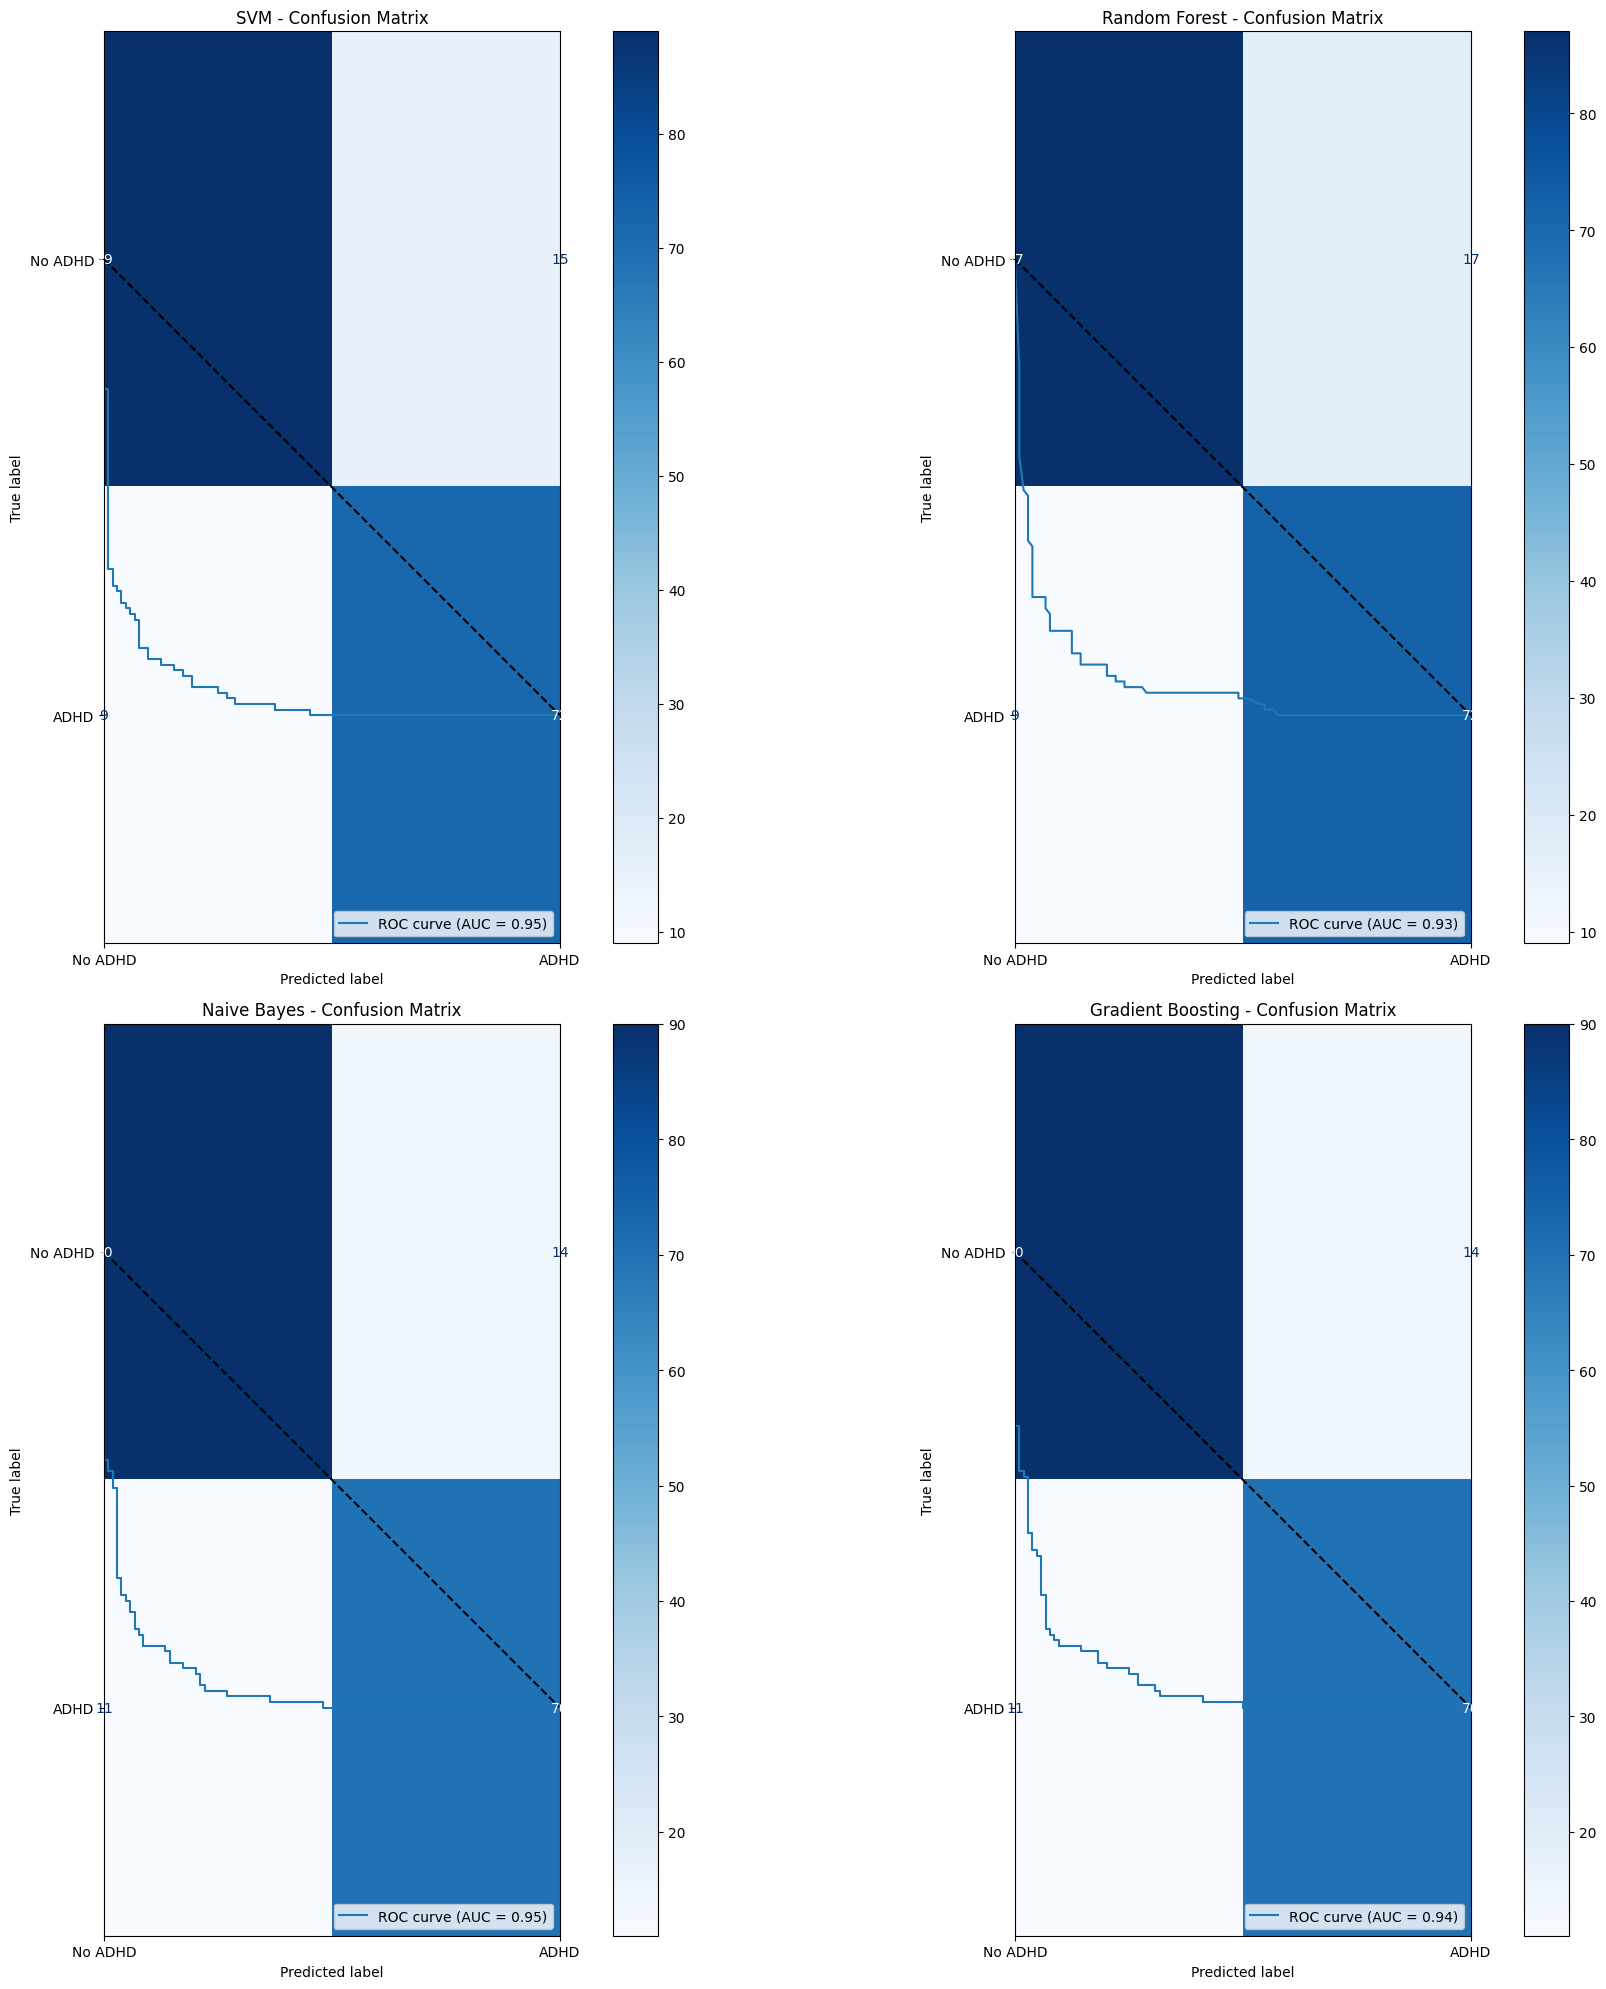

In [208]:
# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.ravel()

# Train and evaluate classifiers
for i, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    y_pred_proba = clf.predict_proba(X_test_pca)[:, 1]
    
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[i].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'{name} - ROC Curve')
    axes[i].legend(loc="lower right")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No ADHD', 'ADHD'])
    disp.plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f'{name} - Confusion Matrix')

plt.tight_layout()
plt.show()

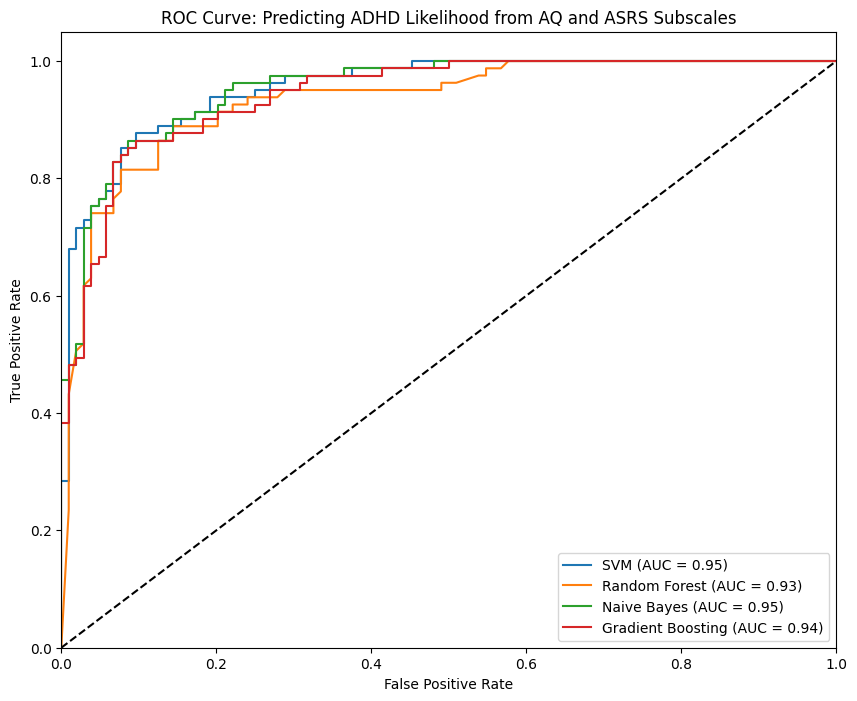

In [209]:
# Visualize ROC curves
plt.figure(figsize=(10, 8))
for name, clf in classifiers.items():
    y_pred_proba = clf.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Predicting ADHD Likelihood from AQ and ASRS Subscales')
plt.legend(loc="lower right")
plt.show()

In [210]:
# Perform cross-validation
cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=5)
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation mean accuracy: 0.8486 (+/- 0.0415)


In [211]:
# Feature importance for Random Forest
rf_clf = classifiers['Random Forest']
feature_importance = rf_clf.feature_importances_
feature_names = X.columns

print("\nFeature Importance:")
for name, importance in zip(feature_names, feature_importance):
    print(f"{name}: {importance:.4f}")


Feature Importance:
aq_social: 0.2257
aq_imagination: 0.5760
aq_attention_detail: 0.0996
asrs_inattentive: 0.0987
